In [401]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
import time
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 15})
sns.set_style('whitegrid')
%matplotlib notebook

## Context

Previous analysis has shown that many brokers earn rewards, largely from quoting, but do not often redeem them. Product would like to determine if an email campaign notifying users of earned rewards will increase rewards redemption (secondary metric), and ultimately quotes/binds (main metrics).

## Get Initial Quote/Bind & Exclusion Data

Data constraints from product team:  

- Quote & Bind Counts by Producer Code, BOP only in the last 6 months (from [Looker](https://attune.looker.com/explore/Attune_Production/quotes_v4?qid=BFzLc3TaD7gvZx9NRHQBxJ&toggle=fil))  
- Exclude codes from a provided list of producers that have opted out of the rewards program  
- Exclude producer codes that have redeemed a reward in the last 6 months

In [2]:
exclude = pd.read_json('../data/denylist.json').rename(columns={0: 'producer_code'})
redeemed = pd.read_csv('../data/rewards_redeemed_pc_2021-05-03.csv')

In [20]:
df = pd.read_csv('../data/rewards_AB_producers_2021-04.csv',
                 index_col=0,
                 names=['producer_code', 'quotes', 'binds'],
                 skiprows=1)

In [21]:
df.count()

quotes    4153
binds     4153
dtype: int64

In [22]:
rmv_filter = (~df.index.isin(exclude.producer_code)) &\
(~df.index.isin(redeemed.guidewire_producer_code))

test_df = df[rmv_filter].copy()
test_df.count()

quotes    3427
binds     3427
dtype: int64

~700 producers were excluded

## Get secondary metric data & compute stats

Secondary metrics include email open rate, email click-through rate, and rewards page visits.  
We will retrieve these metrics from the data warehouse and merge with `test_df`.

In [624]:
from attU.sql import attune_dw_engine

def make_query_tuple(series:pd.Series):
    '''Format series values into a tuple that sqlalchemy can use as
        a params argument
    '''
    return (tuple(series.values.tolist()),)

### Broker segment & user data by producer code

In [626]:
q = '''
    select distinct email as email
      , producer_code
      , case
            when broker_segments ~* 'whole' then 'wholesale'
            when broker_segments ~* 'small' then 'small_retail'
        end as segment
    from crm_agents a
             left join crm_agencies c
                       on a.agency_producer_code = c.producer_code
    where broker_segments ~* 'whole|small'
      and (offboarded = 'No'
        or offboarded is null)
      and producer_code in %s
'''

t = make_query_tuple(test_df.index)
crm_df = pd.read_sql_query(q, con=attune_dw_engine, params=(t,))

In [627]:
#Save data
crm_df[~crm_df.email.isnull()].to_csv('../data/rewards_AB_producers_2021-04_segment_email.csv', 
                                      index=False)
# crm_df = pd.read_csv('../data/rewards_AB_producers_2021-04_segment_email.csv')

###  Rewards page visits

In [629]:
q = '''
select
producer_code
, count(distinct session_id)
from ui_events_v2_skinny
where now() - event_time::timestamp <= '6 months'
and page = '/rewards' and input ~* 'page_enter'
and producer_code in %s
group by 1
'''
t = make_query_tuple(test_df.index)
page_df = pd.read_sql_query(q, con=attune_dw_engine, params=(t,))

In [630]:
# Save data
page_df.to_csv('../data/rewards_AB_producers_2021-04_page_visits.csv', index=False)
# page_df = pd.read_csv('../data/rewards_AB_producers_2021-04_page_visits.csv')

###  Mandrill data per user

In [ ]:
q = '''
select
    email_address as email
     , count(distinct sent_at) filter ( where num_opens > 0 ) num_opened
     , count(distinct sent_at) filter ( where num_clicks > 0 ) num_clicked
     , count(distinct sent_at) filter ( where status = 'sent' ) num_sent
from mandrill_emails
group by email_address
'''
t = make_query_tuple(crm_df.email)
email_df = pd.read_sql_query(q, con=attune_dw_engine)

Add open and click rate columns

In [ ]:
email_df['open_rate'] = email_df.num_opened / email_df.num_sent
email_df['click_rate'] = email_df.num_clicked / email_df.num_sent

### Merge all datasets

In [632]:
merged_df = test_df.reset_index().\
merge(crm_df, on='producer_code', how='left').dropna().\
merge(page_df, on='producer_code', how='left').\
merge(email_df, on='email', how='left').copy()

merged_df.rename(columns={'count':'pc_num_page_visits'}, inplace=True)

### Add producer code level stats

In [ ]:
# Number of users by code
merged_df = merged_df.merge(
    pd.DataFrame(merged_df.groupby('producer_code')['email'].nunique(
    )).reset_index().rename(columns={'email': 'n_users'}),
    on='producer_code', how='left')

# Mandrill email stats
merged_df = merged_df.merge(
    pd.DataFrame(merged_df.groupby('producer_code')['open_rate'].mean().fillna(
        0)).reset_index().rename(columns={'open_rate': 'pc_mean_open_rate'}),
    on='producer_code', how='left')

merged_df = merged_df.merge(
    pd.DataFrame(merged_df.groupby('producer_code')['click_rate'].mean().fillna(
        0)).reset_index().rename(columns={'click_rate': 'pc_mean_click_rate'}),
    on='producer_code', how='left')

merged_df = merged_df.merge(
    pd.DataFrame(merged_df.groupby('producer_code')['num_sent'].mean().fillna(
        0)).reset_index().rename(columns={'num_sent': 'pc_mean_num_sent'}),
    on='producer_code', how='left')

Create dataframe of producer level stats only (remove user level)

In [ ]:
pcstats_df = merged_df.filter(regex='producer|quotes|binds|pc_|n_u').\
    drop_duplicates().fillna(0).copy()

In [638]:
pcstats_df.head(3)

producer_code  quotes  binds  pc_num_page_visits  n_users  \
0     SCOTT00001      97     26                 5.0       93   
93   EVRISK00001      95     19                 2.0        2   
95   REGRIG00001      84     30                32.0       17   

    pc_mean_open_rate  pc_mean_click_rate  pc_mean_num_sent  \
0            0.651672            0.064465         36.811111   
93           0.968232            0.019337        182.000000   
95           0.319462            0.128705         60.470588   

    mean_scaled_stratified  mean_scaled_optimization  
0                 0.384286                  0.379940  
93                0.344286                  0.401273  
95                0.405714                  0.459122

### Add mean-scaled columns

The above dataframe, `pcstats_df`, contains multiple columns of statistics per producer code. We'd like to allocate producers to treatment & control groups such that they are similar across these metrics (when aggregated over the entire group), and have a similar number of users per group. In general, this seems like a combinatorial optimization problem, specifically a multi-dimensional knapsack problem. We can simplify this problem by reducing the statistics columns down to one dimension. We do so by scaling the range of values for each column to the range [0,1] and then taking the mean of all columns.

Below we define two columns `mean_scaled_stratified` and `mean_scaled_optimization`. The former column is mean of all scaled columns of `pcstats_df`, the latter is the same except it excludes the `n_users` column in the aggregation. Each of these will be used in separate optimization schemes.

In [ ]:
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()

# get rid of infs
pcstats_df.replace({np.inf:0}, inplace=True)
merged_df.replace({np.inf:0}, inplace=True)

#Collapse all columns into 1, for use with stratified sampling method
pcstats_df = pcstats_df.join(
    pd.DataFrame(
        scaler.fit_transform(pcstats_df.drop('producer_code', axis=1)).round(2), index=pcstats_df.index
    ).mean(axis=1).rename('mean_scaled_stratified')
)

#Collapse all columns except n_users into 1, for use with OR tools
pcstats_df = pcstats_df.join(
    pd.DataFrame(
        scaler.fit_transform(
            pcstats_df.drop(['producer_code', 'n_users', 'mean_scaled_stratified'], axis=1)
        ), index=pcstats_df.index
    ).mean(axis=1).rename('mean_scaled_optimization')
)

### Save dataframes

In [ ]:
merged_df.to_csv('../data/rewards_AB_producers_2021-04_all_metrics.csv', index=False)
pcstats_df.to_csv('../data/rewards_AB_producers_2021-04_pcstats.csv', index=False)

In [23]:
merged_df = pd.read_csv('../data/rewards_AB_producers_2021-04_all_metrics.csv')

## Analyze Experiment Results

### Get Data

Download data for number of quotes per week for test users from this explore:  
https://attune.looker.com/explore/Attune_development/rewards_ab_groups_06_2021?qid=szsHbIB4uM3fl1VO1ugnoQ

In [271]:
# df = pd.read_csv('../data/rewards_ab_2021-07-01T1339.csv', header=[0,1,2])
df = pd.read_csv('../data/rewards_ab_groups_06_2021_2021-08-02T1408.csv', header=[0,1,2])

In [272]:
df.head(2)

Unnamed: 0_level_0                              segment  \
  Unnamed: 0_level_1 Rewards Ab Groups 06 2021 Test Group   
   Quotes Quote Week      Rewards Ab Groups 06 2021 Email   
0         2021-03-01            9515bellaireins@gmail.com   
1         2021-04-12            insurehoustontx@gmail.com   

                   small_retail                        \
                      treatment                         
   Quotes Bundle Quotes w/ Bind  Quotes Bundle Quotes   
0                           4.0                   5.0   
1                           4.0                   5.0   

                      wholesale                        \
                      treatment                         
   Quotes Bundle Quotes w/ Bind  Quotes Bundle Quotes   
0                           NaN                   NaN   
1                           NaN                   NaN   

                   small_retail                        \
                        control                         
   Quotes Bundle Quotes w/ Bind  Quotes Bundle Quotes   
0                           NaN                   NaN   
1                           NaN                   NaN   

                      wholesale                        
                        control                        
   Quotes Bundle Quotes w/ Bind  Quotes Bundle Quotes  
0                           NaN                   NaN  
1                           NaN                   NaN

Flatten Column Index

In [273]:
new_cols = ('week', 'email', 'small_retail_treatment_binds',
            'small_retail_treatment_quotes', 'wholesale_treatment_binds', 
            'wholesale_treatment_quotes', 'small_retail_control_binds',
            'small_retail_control_quotes', 'wholesale_control_binds', 
            'wholesale_control_quotes')
df.columns = new_cols
df.head(2)

week                      email  small_retail_treatment_binds  \
0  2021-03-01  9515bellaireins@gmail.com                           4.0   
1  2021-04-12  insurehoustontx@gmail.com                           4.0   

   small_retail_treatment_quotes  wholesale_treatment_binds  \
0                            5.0                        NaN   
1                            5.0                        NaN   

   wholesale_treatment_quotes  small_retail_control_binds  \
0                         NaN                         NaN   
1                         NaN                         NaN   

   small_retail_control_quotes  wholesale_control_binds  \
0                          NaN                      NaN   
1                          NaN                      NaN   

   wholesale_control_quotes  
0                       NaN  
1                       NaN

#### Pre-process & define pre- and post- data sets

In [275]:
df['week'] = pd.to_datetime(df.week)
exp_start = pd.to_datetime('05-21-21')
df['exp_ts_delta'] = df.week - exp_start
df.exp_ts_delta.max()

Timedelta('73 days 00:00:00')

In [347]:
pre_exp = df[(df.week >= pd.to_datetime('03-22-21')) & (df.week <= pd.to_datetime('05-17-21'))].copy()
# post_exp = df[(df.exp_ts_delta>='0 days') & (df.exp_ts_delta<='63 days')].copy()
post_exp = df[(df.week > exp_start) & (df.week < pd.to_datetime('07-25-21'))].copy()

### Post-hoc analysis

In [386]:
print(post_exp.email.nunique())
print(post_exp[['email', 'week', 'small_retail_treatment_quotes']].dropna().email.nunique())
print(post_exp[['email', 'week', 'small_retail_control_quotes']].dropna().email.nunique())

print(pre_exp.email.nunique())
print(pre_exp[['email', 'week', 'small_retail_treatment_quotes']].dropna().email.nunique())
print(pre_exp[['email', 'week', 'small_retail_control_quotes']].dropna().email.nunique())

846
431
363
1122
536
513


In [425]:
pre_exp.week.nunique()

9

In [426]:
post_exp.week.nunique()

9

#### Bucket users by pre-experiment status, compare post first-second half

##### n_quotes

In [484]:
pre_post_quotes[['email','pre_exp_quote_bucket']].head()

email pre_exp_quote_bucket
2            crescent@crescentins.com            four_plus
10     shomita@anwarinternational.com            four_plus
3   andrew@insurance4contractors.info            four_plus
4               info@no1insurance.com            four_plus
27             chris@workmangroup.org            four_plus

In [487]:
post_quotes = compare_treatment_subgroups(df, 
                            (df.week > exp_start) & (df.week <= '2021-06-14'),
                            (df.week >= '2021-06-28') & (df.week <= '2021-07-19'),
                            'small_retail_treatment_quotes')

In [565]:
post_quotes_control = compare_treatment_subgroups(df, 
                            (df.week > exp_start) & (df.week <= '2021-06-14'),
                            (df.week >= '2021-06-28') & (df.week <= '2021-07-19'),
                            'small_retail_control_quotes')

In [490]:
post_quotes = post_quotes.merge(
    pre_post_quotes[['email', 'pre_exp_quote_bucket']], on='email')

In [567]:
post_quotes_control = post_quotes_control.merge(
    pre_post_quotes_control[['email', 'pre_exp_quote_bucket']], on='email')

In [491]:
post_quotes.head(2)

email  small_retail_treatment_quotes_grpA  \
0  edemaria@abilityservice.com                                10.0   
1      jay.kibbe@verifyins.net                                11.0   

   small_retail_treatment_quotes_grpB  diff pre_exp_quote_bucket  
0                                 3.0  -7.0            four_plus  
1                                 6.0  -5.0            four_plus

In [493]:
post_quotes.groupby('pre_exp_quote_bucket')['diff'].sum()

pre_exp_quote_bucket
four_plus    -7.0
one           2.0
two_three   -10.0
Name: diff, dtype: float64

In [573]:
post_quotes.groupby('pre_exp_quote_bucket').sum()

small_retail_treatment_quotes_grpA  \
pre_exp_quote_bucket                                       
four_plus                                          158.0   
one                                                 38.0   
two_three                                           78.0   

                      small_retail_treatment_quotes_grpB  diff  
pre_exp_quote_bucket                                            
four_plus                                          151.0  -7.0  
one                                                 40.0   2.0  
two_three                                           68.0 -10.0

In [494]:
post_quotes.groupby('pre_exp_quote_bucket')['email'].nunique()

pre_exp_quote_bucket
four_plus    50
one          24
two_three    37
Name: email, dtype: int64

In [495]:
(post_quotes.groupby('pre_exp_quote_bucket')['diff'].sum() / \
 post_quotes.groupby('pre_exp_quote_bucket')['email'].nunique())

pre_exp_quote_bucket
four_plus   -0.140000
one          0.083333
two_three   -0.270270
dtype: float64

control

In [570]:
post_quotes_control.groupby('pre_exp_quote_bucket')['diff'].sum()

pre_exp_quote_bucket
four_plus    21.0
one           0.0
two_three    -2.0
Name: diff, dtype: float64

In [569]:
post_quotes_control.groupby('pre_exp_quote_bucket').sum()

small_retail_control_quotes_grpA  \
pre_exp_quote_bucket                                     
four_plus                                         97.0   
one                                               26.0   
two_three                                         58.0   

                      small_retail_control_quotes_grpB  diff  
pre_exp_quote_bucket                                          
four_plus                                        118.0  21.0  
one                                               26.0   0.0  
two_three                                         56.0  -2.0

In [571]:
post_quotes_control.groupby('pre_exp_quote_bucket')['email'].nunique()

pre_exp_quote_bucket
four_plus    35
one          18
two_three    34
Name: email, dtype: int64

In [572]:
(post_quotes_control.groupby('pre_exp_quote_bucket')['diff'].sum() / \
 post_quotes_control.groupby('pre_exp_quote_bucket')['email'].nunique())

pre_exp_quote_bucket
four_plus    0.600000
one          0.000000
two_three   -0.058824
dtype: float64

##### n_binds

In [497]:
pre_post_binds[['email','pre_exp_bind_bucket']].head()

email pre_exp_bind_bucket
0  crescent@crescentins.com            two_plus
5  insulandagency@gmail.com            two_plus
6           sang@aclins.com            two_plus
8    victor@viprealtyny.com            two_plus
3     info@no1insurance.com            two_plus

In [498]:
post_binds = compare_treatment_subgroups(df, 
                            (df.week > exp_start) & (df.week <= '2021-06-14'),
                            (df.week >= '2021-06-28') & (df.week <= '2021-07-19'),
                            'small_retail_treatment_binds')

In [576]:
post_binds_control = compare_treatment_subgroups(df, 
                            (df.week > exp_start) & (df.week <= '2021-06-14'),
                            (df.week >= '2021-06-28') & (df.week <= '2021-07-19'),
                            'small_retail_control_binds')

In [499]:
post_binds = post_binds.merge(
    pre_post_binds[['email','pre_exp_bind_bucket']], on='email')

In [500]:
post_binds.head(2)

email  small_retail_treatment_binds_grpA  \
0      jay.kibbe@verifyins.net                                7.0   
1  jzinsurancebroker@gmail.com                                3.0   

   small_retail_treatment_binds_grpB  diff pre_exp_bind_bucket  
0                                2.0  -5.0            two_plus  
1                                0.0  -3.0            two_plus

In [501]:
post_binds.groupby('pre_exp_bind_bucket')['diff'].sum()

pre_exp_bind_bucket
one         -2.0
two_plus   -13.0
zero        -3.0
Name: diff, dtype: float64

In [557]:
post_binds.groupby('pre_exp_bind_bucket').sum()

small_retail_treatment_binds_grpA  \
pre_exp_bind_bucket                                      
one                                               21.0   
two_plus                                          69.0   
zero                                              13.0   

                     small_retail_treatment_binds_grpB  diff  
pre_exp_bind_bucket                                           
one                                               19.0  -2.0  
two_plus                                          56.0 -13.0  
zero                                              10.0  -3.0

In [502]:
post_binds.groupby('pre_exp_bind_bucket')['email'].nunique()

pre_exp_bind_bucket
one         31
two_plus    43
zero        37
Name: email, dtype: int64

In [503]:
(post_binds.groupby('pre_exp_bind_bucket')['diff'].sum() / \
 post_binds.groupby('pre_exp_bind_bucket')['email'].nunique())

pre_exp_bind_bucket
one        -0.064516
two_plus   -0.302326
zero       -0.081081
dtype: float64

##### n_binds with pre-quote buckets

In [504]:
post_binds_qbuckets = post_binds.merge(
    pre_post_quotes[['email','pre_exp_quote_bucket']], on='email')

In [581]:
post_binds_qbuckets_control = post_binds_control.merge(
    pre_post_quotes_control[['email','pre_exp_quote_bucket']], on='email')

In [507]:
post_binds_qbuckets.head(2)

email  small_retail_treatment_binds_grpA  \
0      jay.kibbe@verifyins.net                                7.0   
1  jzinsurancebroker@gmail.com                                3.0   

   small_retail_treatment_binds_grpB  diff pre_exp_bind_bucket  \
0                                2.0  -5.0            two_plus   
1                                0.0  -3.0            two_plus   

  pre_exp_quote_bucket  
0            four_plus  
1            four_plus

In [582]:
post_binds_qbuckets_control.head(2)

email  small_retail_control_binds_grpA  \
0  sales@zarains.com                              3.0   
1   exxceed1@msn.com                              3.0   

   small_retail_control_binds_grpB  diff pre_exp_quote_bucket  
0                              0.0  -3.0            two_three  
1                              0.0  -3.0            two_three

In [508]:
post_binds_qbuckets.groupby('pre_exp_quote_bucket')['diff'].sum()

pre_exp_quote_bucket
four_plus   -12.0
one          -3.0
two_three    -3.0
Name: diff, dtype: float64

In [583]:
post_binds_qbuckets.groupby('pre_exp_quote_bucket').sum()

small_retail_treatment_binds_grpA  \
pre_exp_quote_bucket                                      
four_plus                                          67.0   
one                                                 8.0   
two_three                                          28.0   

                      small_retail_treatment_binds_grpB  diff  
pre_exp_quote_bucket                                           
four_plus                                          55.0 -12.0  
one                                                 5.0  -3.0  
two_three                                          25.0  -3.0

In [509]:
post_binds_qbuckets.groupby('pre_exp_quote_bucket')['email'].nunique()

pre_exp_quote_bucket
four_plus    50
one          24
two_three    37
Name: email, dtype: int64

In [510]:
(post_binds_qbuckets.groupby('pre_exp_quote_bucket')['diff'].sum() / \
 post_binds_qbuckets.groupby('pre_exp_quote_bucket')['email'].nunique())

pre_exp_quote_bucket
four_plus   -0.240000
one         -0.125000
two_three   -0.081081
dtype: float64

Control

In [584]:
post_binds_qbuckets_control.groupby('pre_exp_quote_bucket')['diff'].sum()

pre_exp_quote_bucket
four_plus   -5.0
one          4.0
two_three   -7.0
Name: diff, dtype: float64

In [589]:
post_binds_qbuckets_control.groupby('pre_exp_quote_bucket').sum()

small_retail_control_binds_grpA  \
pre_exp_quote_bucket                                    
four_plus                                        42.0   
one                                               8.0   
two_three                                        23.0   

                      small_retail_control_binds_grpB  diff  
pre_exp_quote_bucket                                         
four_plus                                        37.0  -5.0  
one                                              12.0   4.0  
two_three                                        16.0  -7.0

In [587]:
post_binds_qbuckets_control.groupby('pre_exp_quote_bucket')['email'].nunique()

pre_exp_quote_bucket
four_plus    35
one          18
two_three    34
Name: email, dtype: int64

In [588]:
(post_binds_qbuckets.groupby('pre_exp_quote_bucket')['diff'].sum() / \
 post_binds_qbuckets.groupby('pre_exp_quote_bucket')['email'].nunique())

pre_exp_quote_bucket
four_plus   -0.240000
one         -0.125000
two_three   -0.081081
dtype: float64

#### Bucket users by pre-experiment status, compare pre-post

In [436]:
pre_post_quotes = compare_treatment_subgroups(df, 
                            (df.week >= '03-22-21') & (df.week < exp_start), 
                            (df.week > exp_start) & (df.week <= '2021-07-19'),
                            'small_retail_treatment_quotes')

pre_post_binds = compare_treatment_subgroups(df, 
                            (df.week >= '03-22-21') & (df.week < exp_start), 
                            (df.week > exp_start) & (df.week <= '2021-07-19'),
                            'small_retail_treatment_binds')

In [521]:
pre_post_quotes_control = compare_treatment_subgroups(df, 
                            (df.week >= '03-22-21') & (df.week < exp_start), 
                            (df.week > exp_start) & (df.week <= '2021-07-19'),
                            'small_retail_control_quotes')

In [529]:
pre_post_binds_control = compare_treatment_subgroups(df, 
                            (df.week >= '03-22-21') & (df.week < exp_start), 
                            (df.week > exp_start) & (df.week <= '2021-07-19'),
                            'small_retail_control_binds')

In [517]:
df[(df.week >= '03-22-21') & (df.week < exp_start)].week.nunique()
df[(df.week > exp_start) & (df.week <= '2021-07-19')].week.nunique()

9

##### Num users quoted

In [547]:
df[(df.week >= '03-22-21') & (df.week < exp_start)
   ].dropna(subset=['small_retail_treatment_quotes']).email.nunique()

536

In [550]:
df[(df.week >= '03-22-21') & (df.week < exp_start)
   ].dropna(subset=['small_retail_control_quotes']).email.nunique()

513

In [551]:
df[(df.week > exp_start) & (df.week <= '2021-07-19')
   ].dropna(subset=['small_retail_treatment_quotes']).email.nunique()

431

In [549]:
df[(df.week > exp_start) & (df.week <= '2021-07-19')
   ].dropna(subset=['small_retail_control_quotes']).email.nunique()

363

<IPython.core.display.Javascript object>


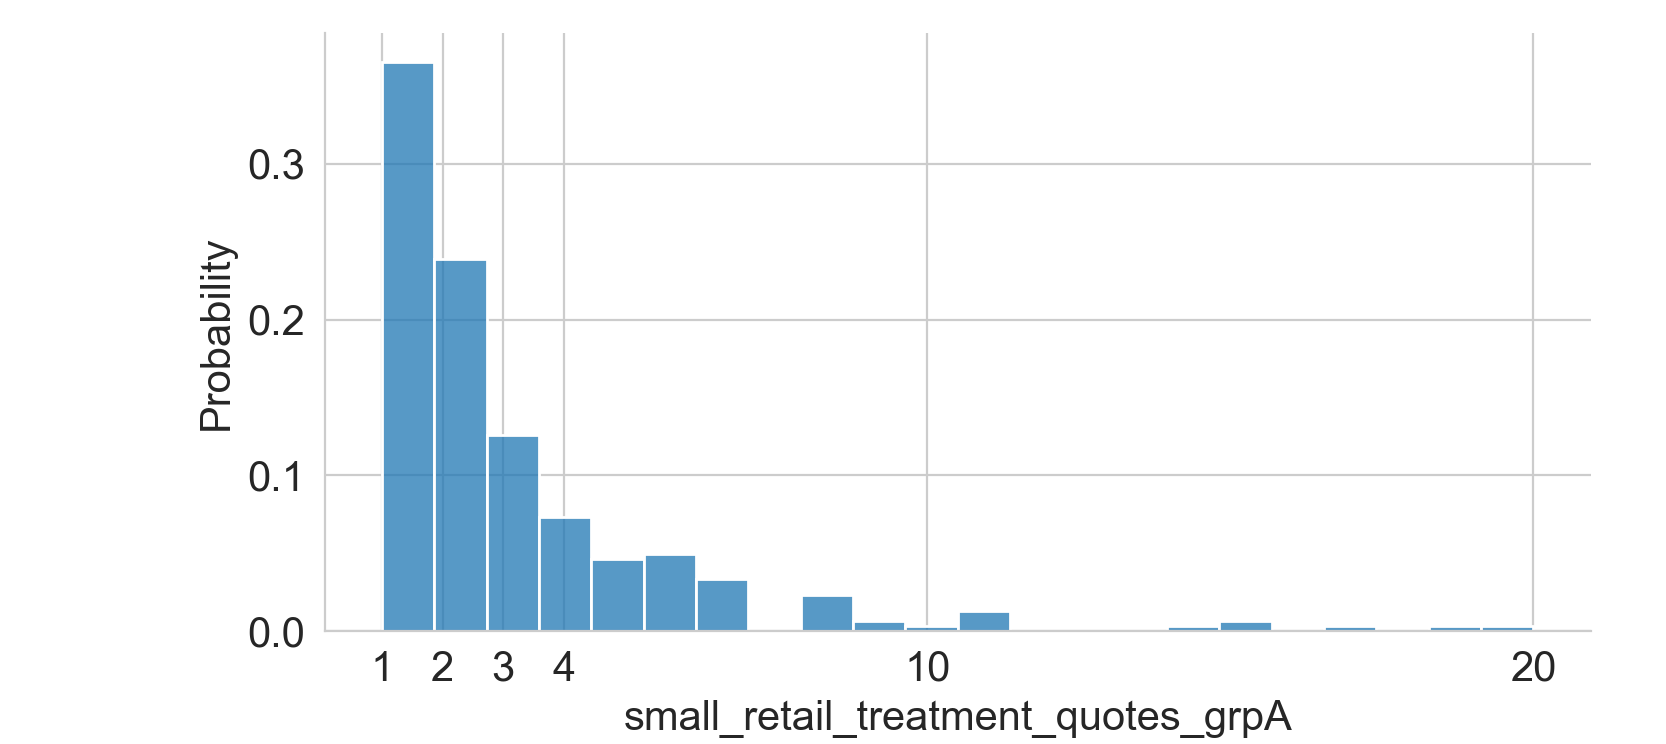

In [439]:
g = sns.displot(pre_post_quotes.small_retail_treatment_quotes_grpA, stat='probability')
g.ax.set_xticks([1,2,3,4,10,20]);

Bucketing into 1, 2-3, 4+ yields similar sized groups

In [442]:
pre_post_quotes.groupby('small_retail_treatment_quotes_grpA')['email'].nunique()

small_retail_treatment_quotes_grpA
1.0     110
2.0      72
3.0      38
4.0      22
5.0      14
6.0      15
7.0      10
8.0       7
9.0       2
10.0      1
11.0      4
14.0      1
15.0      2
17.0      1
19.0      1
20.0      1
Name: email, dtype: int64

In [443]:
def quote_bucket(nquotes):
    '''custom quote freq bucket'''
    if nquotes==0:
        return 'zero'
    elif nquotes==1:
        return 'one'
    elif (nquotes>1 and nquotes<=3):
        return 'two_three'
    else:
        return 'four_plus'

<IPython.core.display.Javascript object>


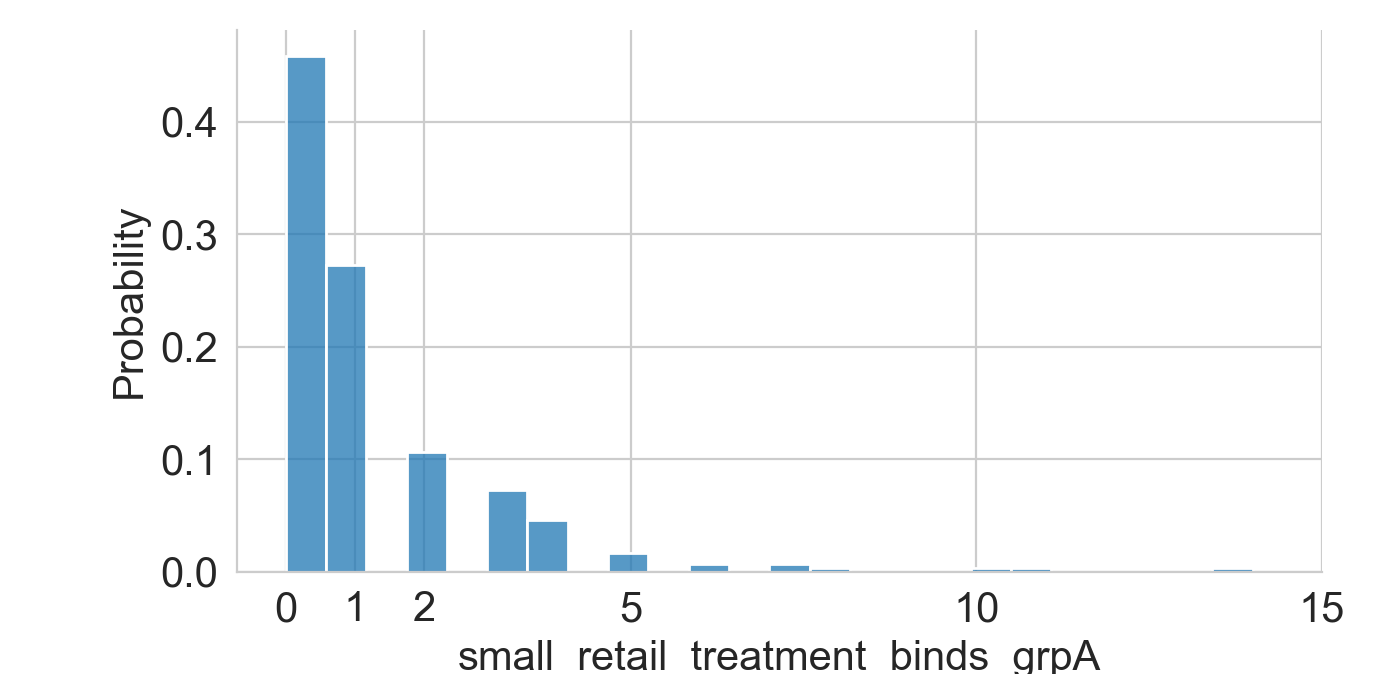

In [451]:
g = sns.displot(pre_post_binds.small_retail_treatment_binds_grpA, stat='probability')
g.ax.set_xticks([0,1,2,5,10,15]);

Bucketing into 0, 1, 2+ yields similar sized groups

In [455]:
pre_post_binds.groupby('small_retail_treatment_binds_grpA')['email'].nunique().cumsum()

small_retail_treatment_binds_grpA
0.0     138
1.0     220
2.0     252
3.0     274
4.0     288
5.0     293
6.0     295
7.0     297
8.0     298
10.0    299
11.0    300
14.0    301
Name: email, dtype: int64

In [457]:
def bind_bucket(nbinds):
    '''custom bind volume bucket'''
    if nbinds==0:
        return 'zero'
    elif nbinds==1:
        return 'one'
    else:
        return 'two_plus'

##### Pre vs post n_quotes change per quote_volume_bucket

In [444]:
pre_post_quotes['pre_exp_quote_bucket'] = pre_post_quotes.small_retail_treatment_quotes_grpA.map(
    lambda x: quote_bucket(x))

In [523]:
pre_post_quotes_control['pre_exp_quote_bucket'] = pre_post_quotes_control.small_retail_control_quotes_grpA.map(
    lambda x: quote_bucket(x))

In [445]:
pre_post_quotes.groupby('pre_exp_quote_bucket')['diff'].sum()

pre_exp_quote_bucket
four_plus   -100.0
one           89.0
two_three     36.0
Name: diff, dtype: float64

In [524]:
pre_post_quotes_control.groupby('pre_exp_quote_bucket')['diff'].sum()

pre_exp_quote_bucket
four_plus   -118.0
one           56.0
two_three      7.0
Name: diff, dtype: float64

In [447]:
pre_post_quotes.groupby('pre_exp_quote_bucket')['email'].nunique()

pre_exp_quote_bucket
four_plus     81
one          110
two_three    110
Name: email, dtype: int64

In [525]:
pre_post_quotes_control.groupby('pre_exp_quote_bucket')['email'].nunique()

pre_exp_quote_bucket
four_plus    60
one          97
two_three    85
Name: email, dtype: int64

In [481]:
(pre_post_quotes.groupby('pre_exp_quote_bucket')['diff'].sum() / \
 pre_post_quotes.groupby('pre_exp_quote_bucket')['email'].nunique())

pre_exp_quote_bucket
four_plus   -1.234568
one          0.809091
two_three    0.327273
dtype: float64

In [526]:
(pre_post_quotes_control.groupby('pre_exp_quote_bucket')['diff'].sum() / \
 pre_post_quotes_control.groupby('pre_exp_quote_bucket')['email'].nunique())

pre_exp_quote_bucket
four_plus   -1.966667
one          0.577320
two_three    0.082353
dtype: float64

##### Pre vs post n_binds change per bind_volume_bucket

In [460]:
pre_post_binds['pre_exp_bind_bucket'] = pre_post_binds.small_retail_treatment_binds_grpA.map(
    lambda x: bind_bucket(x))

In [468]:
pre_post_binds.groupby('pre_exp_bind_bucket')['diff'].sum()

pre_exp_bind_bucket
one          -7.0
two_plus   -100.0
zero         54.0
Name: diff, dtype: float64

In [556]:
pre_post_binds.groupby('pre_exp_bind_bucket').sum()

small_retail_treatment_binds_grpA  \
pre_exp_bind_bucket                                      
one                                               82.0   
two_plus                                         280.0   
zero                                               0.0   

                     small_retail_treatment_binds_grpB   diff  
pre_exp_bind_bucket                                            
one                                               75.0   -7.0  
two_plus                                         180.0 -100.0  
zero                                              54.0   54.0

In [469]:
pre_post_binds.groupby('pre_exp_bind_bucket')['email'].nunique()

pre_exp_bind_bucket
one          82
two_plus     81
zero        138
Name: email, dtype: int64

In [470]:
pre_post_binds.groupby('pre_exp_bind_bucket')['diff'].sum(
) / pre_post_binds.groupby('pre_exp_bind_bucket')['email'].nunique()

pre_exp_bind_bucket
one        -0.085366
two_plus   -1.234568
zero        0.391304
dtype: float64

##### Pre vs post n_binds change per quote_volume_bucket

In [512]:
pre_post_binds_qbuckets = pre_post_binds.merge(
    pre_post_quotes[['email','pre_exp_quote_bucket']], on='email')

In [530]:
pre_post_binds_qbuckets_control = pre_post_binds_control.merge(
    pre_post_quotes_control[['email','pre_exp_quote_bucket']], on='email')

In [554]:
pre_post_binds_qbuckets.groupby('pre_exp_quote_bucket').sum()

small_retail_treatment_binds_grpA  \
pre_exp_quote_bucket                                      
four_plus                                         237.0   
one                                                35.0   
two_three                                          90.0   

                      small_retail_treatment_binds_grpB  diff  
pre_exp_quote_bucket                                           
four_plus                                         168.0 -69.0  
one                                                35.0   0.0  
two_three                                         106.0  16.0

In [513]:
pre_post_binds_qbuckets.groupby('pre_exp_quote_bucket')['diff'].sum()

pre_exp_quote_bucket
four_plus   -69.0
one           0.0
two_three    16.0
Name: diff, dtype: float64

In [531]:
pre_post_binds_qbuckets_control.groupby('pre_exp_quote_bucket')['diff'].sum()

pre_exp_quote_bucket
four_plus   -90.0
one          18.0
two_three     2.0
Name: diff, dtype: float64

In [555]:
pre_post_binds_qbuckets_control.groupby('pre_exp_quote_bucket').sum()

small_retail_control_binds_grpA  \
pre_exp_quote_bucket                                    
four_plus                                       190.0   
one                                              26.0   
two_three                                        74.0   

                      small_retail_control_binds_grpB  diff  
pre_exp_quote_bucket                                         
four_plus                                       100.0 -90.0  
one                                              44.0  18.0  
two_three                                        76.0   2.0

In [514]:
pre_post_binds_qbuckets.groupby('pre_exp_quote_bucket')['email'].nunique()

pre_exp_quote_bucket
four_plus     81
one          110
two_three    110
Name: email, dtype: int64

In [532]:
pre_post_binds_qbuckets_control.groupby('pre_exp_quote_bucket')['email'].nunique()

pre_exp_quote_bucket
four_plus    60
one          97
two_three    85
Name: email, dtype: int64

In [515]:
pre_post_binds_qbuckets.groupby('pre_exp_quote_bucket')['diff'].sum(
) / pre_post_binds_qbuckets.groupby('pre_exp_quote_bucket')['email'].nunique()

pre_exp_quote_bucket
four_plus   -0.851852
one          0.000000
two_three    0.145455
dtype: float64

In [533]:
pre_post_binds_qbuckets_control.groupby('pre_exp_quote_bucket')['diff'].sum(
) / pre_post_binds_qbuckets_control.groupby('pre_exp_quote_bucket')['email'].nunique()

pre_exp_quote_bucket
four_plus   -1.500000
one          0.185567
two_three    0.023529
dtype: float64

Define testing function

In [282]:
def create_bootstrap_interval(alpha, data):
    """
    Calculates the confidence interval around the mean of the data
    using a bootstrap method
    Parameters
    ----------
    alpha : float
            Probability that an rv will be drawn from the returned range.
            Each value should be in the range [0, 1].
    data : np.array
        The distribution of data to compute an interval on.
    Returns
    -------
    np.array
        end-points of range that contain ``100 * alpha %`` of the data's
        possible values.
    """
    bootstrap_mean_list = []
    np.random.seed(seed=0)
    for _ in range(10000):
        bootstrap_mean = np.random.choice(data, len(data)).mean()
        bootstrap_mean_list.append(bootstrap_mean)
    lower_quantile = (1-alpha)/2
    upper_quantile = 1-lower_quantile
    lower, upper = np.quantile(bootstrap_mean_list, [lower_quantile, upper_quantile])
    return lower, upper, data.mean()

In [ ]:
# def test():

#     diff_dist = []
#     for _ in range(3000):
#         diff = calc_bootstrapped_sample_mean(pre_exp, 'small_retail_treatment_quotes', 7) - \
#         calc_bootstrapped_sample_mean(pre_exp, 'small_retail_control_quotes', 7)
#         diff_dist.append(diff)

In [ ]:
pre_exp_small_retail_mean_diff_dist = []
for i in range(3000):
    diff = calc_bootstrapped_sample_mean(pre_exp, 'small_retail_treatment_quotes', 7) - \
    calc_bootstrapped_sample_mean(pre_exp, 'small_retail_control_quotes', 7)
    pre_exp_small_retail_mean_diff_dist.append(diff)

In [ ]:
bdf = pd.concat(
    [pd.DataFrame({'data': pre_exp_small_retail_mean_diff_dist, 'group': 'pre'}),
     pd.DataFrame({'data': post_exp_small_retail_mean_diff_dist, 'group': 'post'})]
)

In [ ]:
bdf[bdf.group=='post']['data'].agg(lambda x: 52*np.array(create_bootstrap_interval(.95, x)))

In [ ]:
ttest_ind(post_exp_small_retail_mean_diff_dist,
          pre_exp_small_retail_mean_diff_dist, alternative='larger', value=0.01)

#### Outlier detection

- binds significance for last 3 weeks vs other 3 week periods. 
- other metric significance tests pre vs post
- Gaming the system useres
>- Anomalous users in terms of bind difference. 
>- total users with N binds pre vs post

In [527]:
def compare_treatment_subgroups(post_exp_data_df, groupA_filter, groupB_filter, metric_col):
    '''
    Compare subgroups of a test group for a particular metric,
    where `diff` column is change in .sum() of metric from A to B, 
    i.e. B_metric_sum - A_metric_sum
    '''
    groupA = pd.DataFrame(
        post_exp_data_df[groupA_filter].dropna(subset=[metric_col]).groupby('email')[
            metric_col].sum().sort_values(ascending=False)
    ).reset_index()

    groupB = pd.DataFrame(
        post_exp_data_df[groupB_filter].dropna(subset=[metric_col]).groupby('email')[
            metric_col].sum().sort_values(ascending=False)
    ).reset_index()

    comp = groupA.merge(groupB, on='email', suffixes=('_grpA', '_grpB'))
    comp['diff'] = comp[metric_col+'_grpB'] - comp[metric_col+'_grpA']

    return comp.sort_values(by='diff', ascending=True)

In [288]:
post_exp.week.sort_values().unique()

array(['2021-05-24T00:00:00.000000000', '2021-05-31T00:00:00.000000000',
       '2021-06-07T00:00:00.000000000', '2021-06-14T00:00:00.000000000',
       '2021-06-21T00:00:00.000000000', '2021-06-28T00:00:00.000000000',
       '2021-07-05T00:00:00.000000000', '2021-07-12T00:00:00.000000000',
       '2021-07-19T00:00:00.000000000'], dtype='datetime64[ns]')

First 3 & Last 3 weeks

In [292]:
comp = compare_treatment_subgroups(post_exp, 
                            (post_exp.week <= '2021-06-07'), 
                            (post_exp.week >= '2021-07-05'),
                            'small_retail_treatment_binds')

In [328]:
comp_quotes = compare_treatment_subgroups(post_exp, 
                            (post_exp.week <= '2021-06-07'), 
                            (post_exp.week >= '2021-07-05'),
                            'small_retail_treatment_quotes')

Quotes

<IPython.core.display.Javascript object>


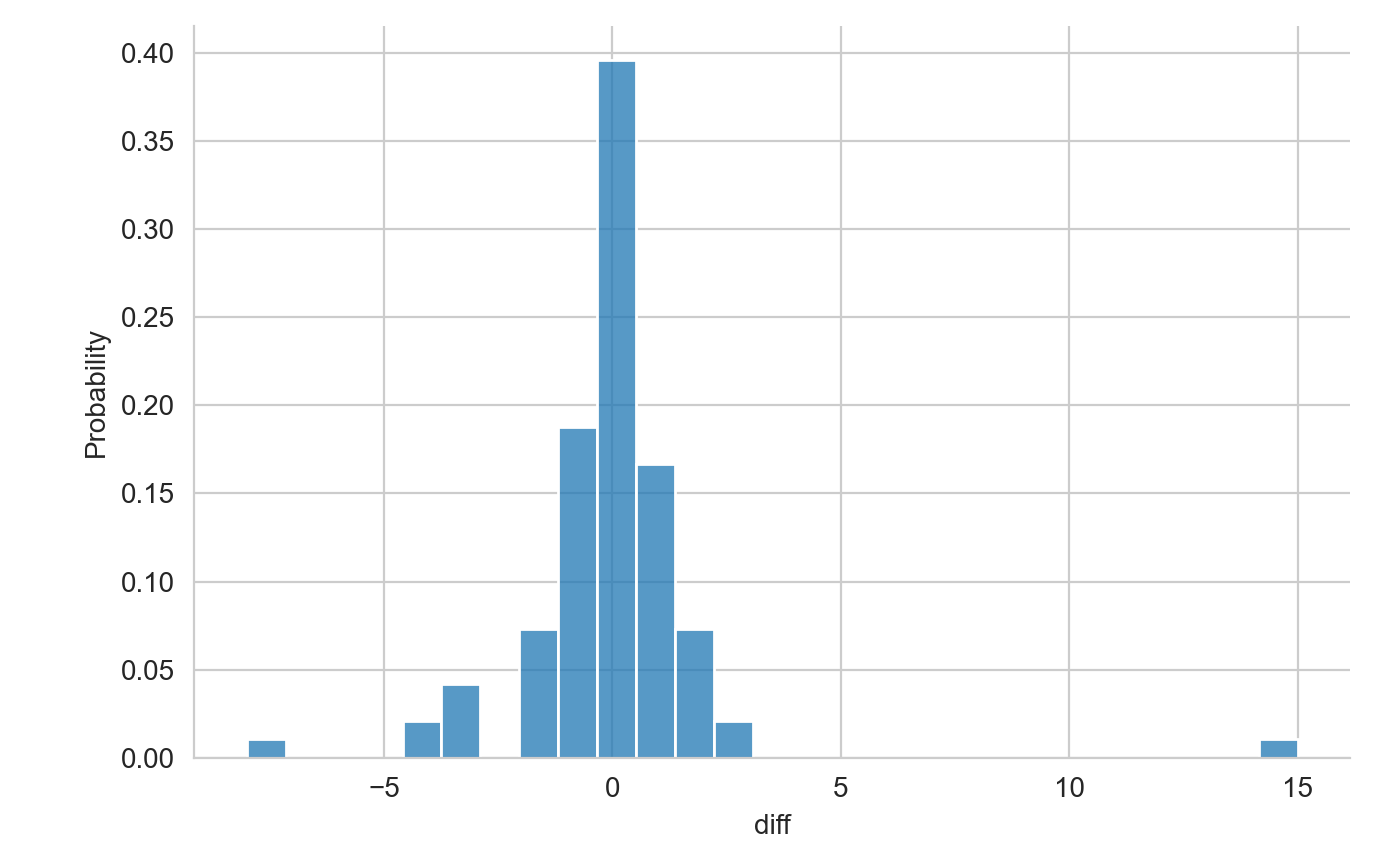

In [329]:
sns.displot(comp_quotes['diff'], stat='probability')

In [330]:
comp_quotes[comp_quotes['diff']>10]

email  small_retail_treatment_quotes_grpA  \
26  stephen@texasinsuranceoptions.net                                 3.0   

    small_retail_treatment_quotes_grpB  diff  
26                                18.0  15.0

In [331]:
comp_quotes[comp_quotes['diff']<-5]

email  small_retail_treatment_quotes_grpA  \
1  edemaria@abilityservice.com                                 9.0   

   small_retail_treatment_quotes_grpB  diff  
1                                 1.0  -8.0

Binds

<IPython.core.display.Javascript object>


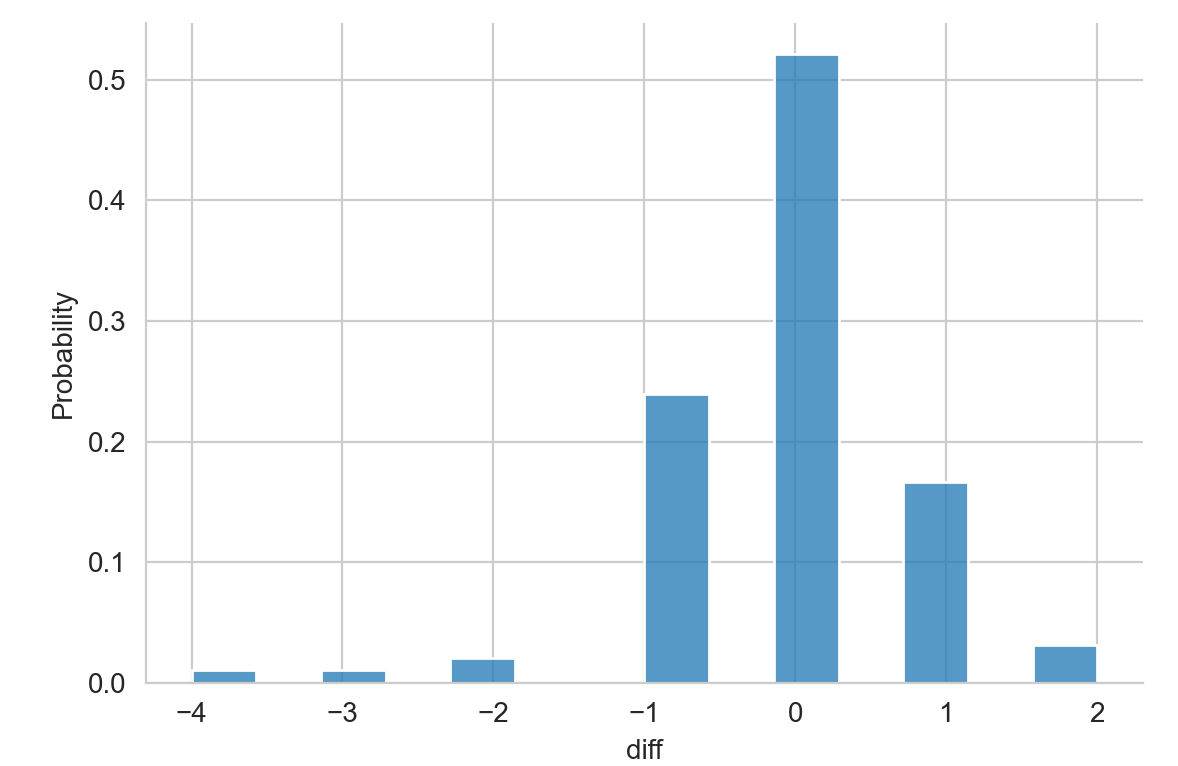

In [310]:
sns.displot(comp['diff'], stat='probability')

In [317]:
comp[comp['diff']<=-2]

email  small_retail_treatment_binds_grpA  \
0       jay.kibbe@verifyins.net                                6.0   
1   jzinsurancebroker@gmail.com                                3.0   
3       etaxinsurance@gmail.com                                3.0   
13         vincent@bvagency.org                                2.0   

    small_retail_treatment_binds_grpB  diff  
0                                 2.0  -4.0  
1                                 0.0  -3.0  
3                                 1.0  -2.0  
13                                0.0  -2.0

In [318]:
comp[comp['diff']>=2]

email  small_retail_treatment_binds_grpA  \
46        ben@primepointinsurance.com                                1.0   
58        tracie@mattinainsurance.com                                0.0   
11  stephen@texasinsuranceoptions.net                                2.0   

    small_retail_treatment_binds_grpB  diff  
46                                3.0   2.0  
58                                2.0   2.0  
11                                4.0   2.0

Second 3 weeks & Last 3 weeks

In [319]:
comp = compare_treatment_subgroups(post_exp, 
                            (post_exp.week >= '2021-06-14') & (post_exp.week <= '2021-06-28'), 
                            (post_exp.week >= '2021-07-05'),
                            'small_retail_treatment_binds')

In [332]:
comp_quotes = compare_treatment_subgroups(post_exp, 
                            (post_exp.week >= '2021-06-14') & (post_exp.week <= '2021-06-28'), 
                            (post_exp.week >= '2021-07-05'),
                            'small_retail_treatment_quotes')

Quotes

<IPython.core.display.Javascript object>


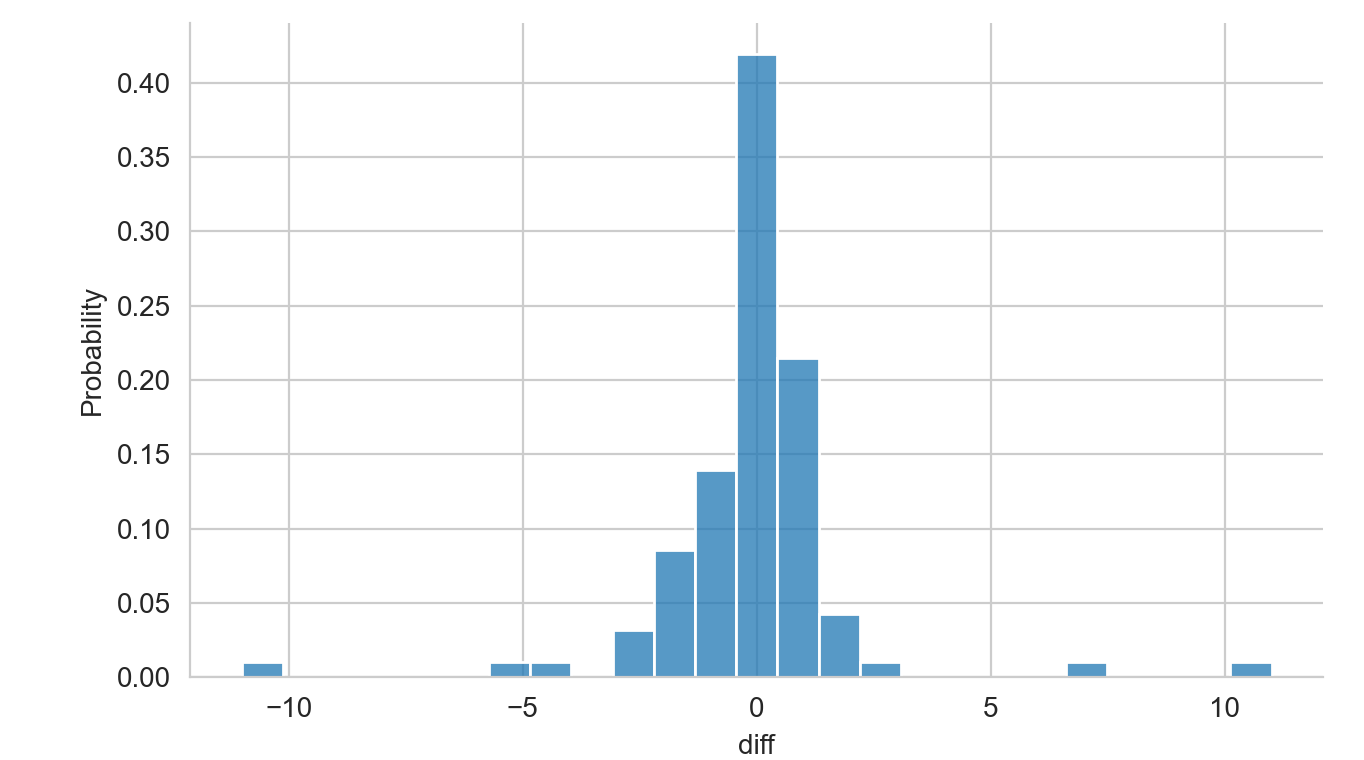

In [333]:
sns.displot(comp_quotes['diff'], stat='probability')

In [335]:
comp_quotes[comp_quotes['diff']<=-5]

email  small_retail_treatment_quotes_grpA  \
0           phi@orchidag.com                                17.0   
1  insurehoustontx@gmail.com                                 9.0   

   small_retail_treatment_quotes_grpB  diff  
0                                 6.0 -11.0  
1                                 4.0  -5.0

In [337]:
comp_quotes[comp_quotes['diff']>=5]

email  small_retail_treatment_quotes_grpA  \
32        jaclyn.ottman@iscential.com                                 2.0   
2   stephen@texasinsuranceoptions.net                                 7.0   

    small_retail_treatment_quotes_grpB  diff  
32                                 9.0   7.0  
2                                 18.0  11.0

Binds

<IPython.core.display.Javascript object>


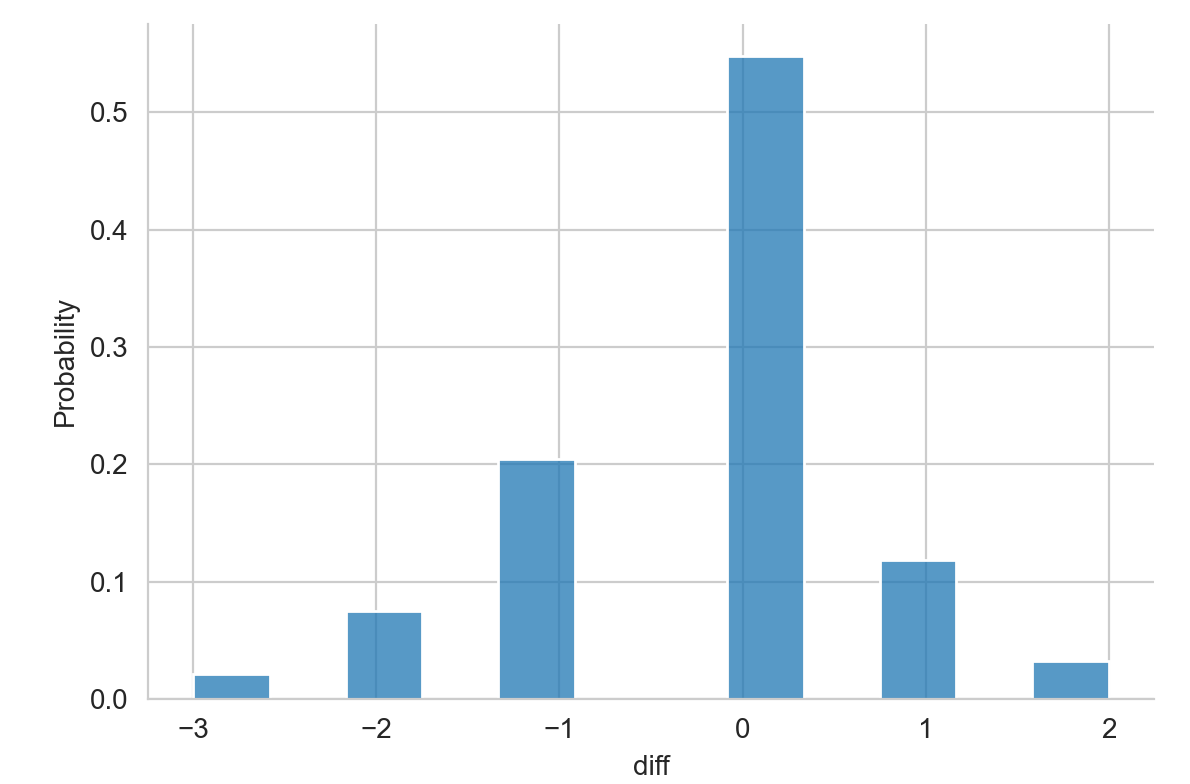

In [320]:
sns.displot(comp['diff'], stat='probability')

In [321]:
comp[comp['diff']<=-2]

email  small_retail_treatment_binds_grpA  \
1           insurehoustontx@gmail.com                                6.0   
2             jay.kibbe@verifyins.net                                5.0   
0   stephen@texasinsuranceoptions.net                                6.0   
3                   rasutnick@aol.com                                3.0   
6          truittinfo@truitttexas.com                                3.0   
8             rickey@psainsurance.com                                2.0   
15      mjdemaio@centraljerseyins.com                                2.0   
14               vincent@bvagency.org                                2.0   
11               rivky@silbagency.com                                2.0   

    small_retail_treatment_binds_grpB  diff  
1                                 3.0  -3.0  
2                                 2.0  -3.0  
0                                 4.0  -2.0  
3                                 1.0  -2.0  
6                                 1.0  -2.0  
8                                 0.0  -2.0  
15                                0.0  -2.0  
14                                0.0  -2.0  
11                                0.0  -2.0

In [322]:
comp[comp['diff']>=2]

email  small_retail_treatment_binds_grpA  \
27  liba@hirschfeldandassociates.com                                1.0   
72       dsilva@nycbusinessgroup.com                                0.0   
80             aa@aainsbrokerage.com                                0.0   

    small_retail_treatment_binds_grpB  diff  
27                                3.0   2.0  
72                                2.0   2.0  
80                                2.0   2.0

second and 5th 3 weeks

In [338]:
comp = compare_treatment_subgroups(post_exp, 
                            (post_exp.week >= '2021-05-31') & (post_exp.week <= '2021-06-14'), 
                            (post_exp.week >= '2021-06-21') & (post_exp.week <= '2021-07-05'),
                            'small_retail_treatment_binds')

comp_quotes = compare_treatment_subgroups(post_exp, 
                            (post_exp.week >= '2021-05-31') & (post_exp.week <= '2021-06-14'), 
                            (post_exp.week >= '2021-06-21') & (post_exp.week <= '2021-07-05'),
                            'small_retail_treatment_quotes')

Quotes

<IPython.core.display.Javascript object>


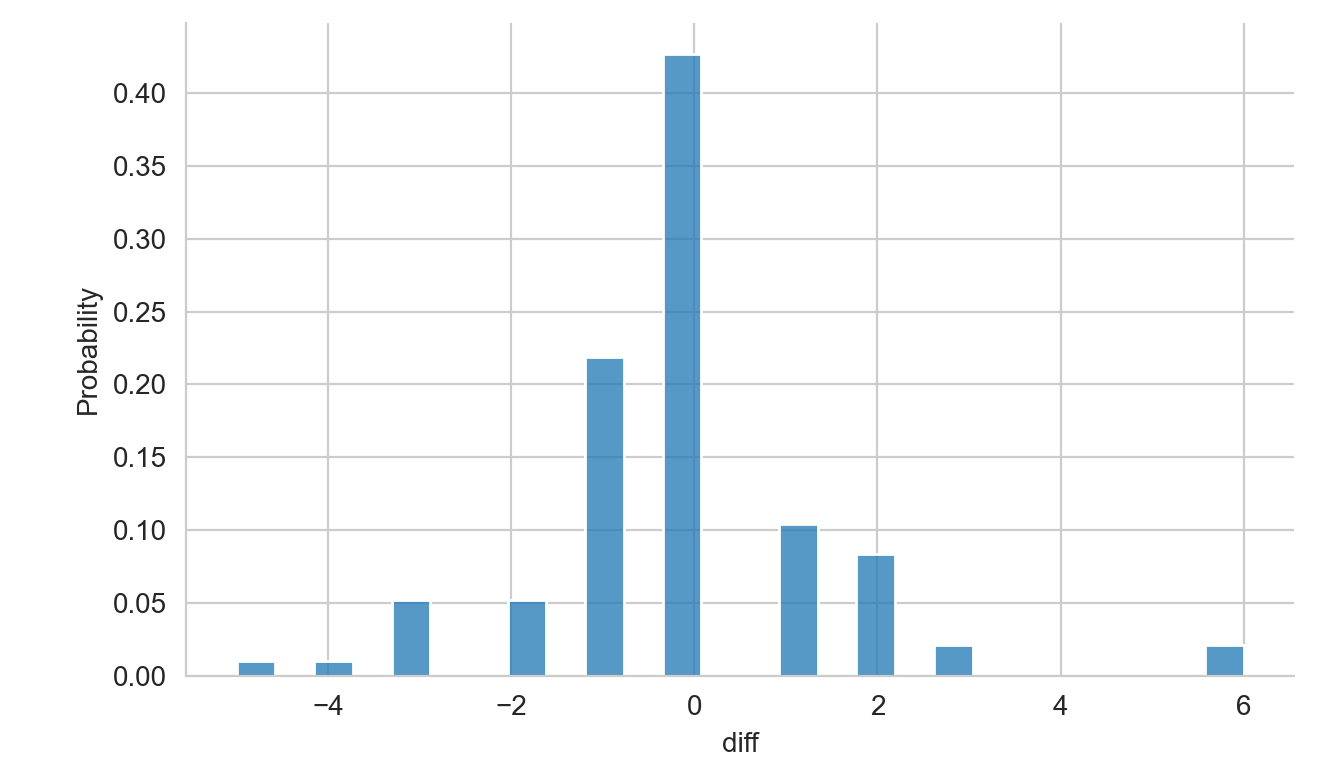

In [339]:
sns.displot(comp_quotes['diff'], stat='probability')

In [340]:
comp_quotes[comp_quotes['diff']>=5]

email  small_retail_treatment_quotes_grpA  \
4   stephen@texasinsuranceoptions.net                                 5.0   
78        ben@primepointinsurance.com                                 1.0   

    small_retail_treatment_quotes_grpB  diff  
4                                 11.0   6.0  
78                                 7.0   6.0

In [341]:
comp_quotes[comp_quotes['diff']<-3]

email  small_retail_treatment_quotes_grpA  \
0  edemaria@abilityservice.com                                 7.0   
5           mhersko@jnrins.com                                 5.0   

   small_retail_treatment_quotes_grpB  diff  
0                                 2.0  -5.0  
5                                 1.0  -4.0

Binds

<IPython.core.display.Javascript object>


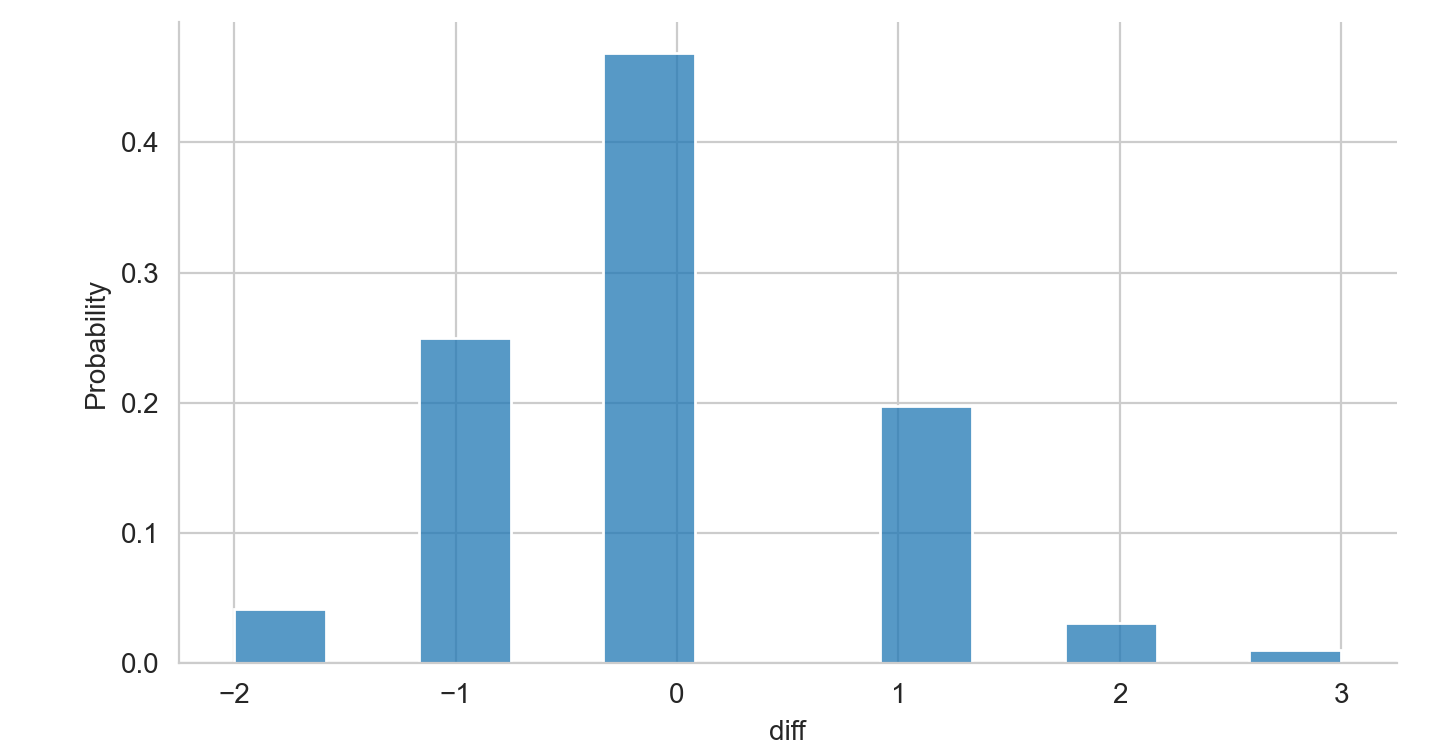

In [323]:
sns.displot(comp['diff'], stat='probability')

In [324]:
comp[comp['diff']<=-2]

email  small_retail_treatment_binds_grpA  \
4          rasutnick@aol.com                                3.0   
5   crescent@crescentins.com                                3.0   
6         mhersko@jnrins.com                                3.0   
10    yakov@igiinsurance.com                                2.0   

    small_retail_treatment_binds_grpB  diff  
4                                 1.0  -2.0  
5                                 1.0  -2.0  
6                                 1.0  -2.0  
10                                0.0  -2.0

In [325]:
comp[comp['diff']>=2]

email  small_retail_treatment_binds_grpA  \
22           info@insuredasap.com                                1.0   
51    ben@primepointinsurance.com                                1.0   
70  mjdemaio@centraljerseyins.com                                0.0   
11      insurehoustontx@gmail.com                                2.0   

    small_retail_treatment_binds_grpB  diff  
22                                3.0   2.0  
51                                3.0   2.0  
70                                2.0   2.0  
11                                5.0   3.0

In [327]:
comp['diff'].sum()

-4.0

#### bind/quote ratio

In [ ]:
# pre_exp = df[(df.week >= pd.to_datetime('03-22-21')) & (df.week <= pd.to_datetime('05-17-21'))].copy()
# post_exp = df[(df.week > exp_start) & (df.week < pd.to_datetime('07-25-21'))].copy()

In [355]:
comp = compare_treatment_subgroups(df, 
                            (df.week >= '03-22-21') & (df.week < exp_start), 
                            (df.week > exp_start) & (df.week <= '2021-07-05'),
                            'small_retail_treatment_quotes')

comp_binds = compare_treatment_subgroups(df, 
                            (df.week >= '03-22-21') & (df.week < exp_start), 
                            (df.week > exp_start) & (df.week <= '2021-07-05'),
                            'small_retail_treatment_binds')

<IPython.core.display.Javascript object>


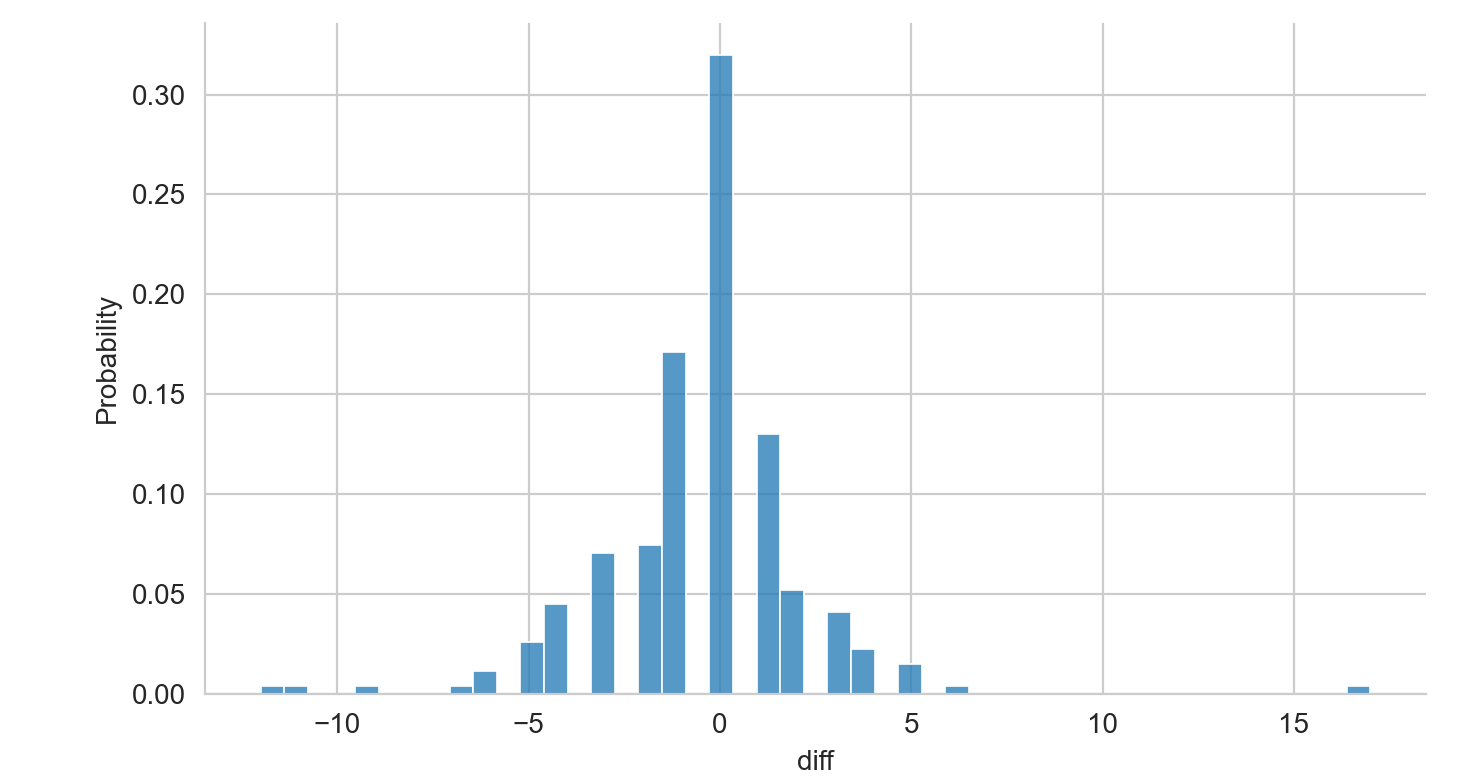

In [354]:
sns.displot(comp['diff'], stat='probability')

<IPython.core.display.Javascript object>


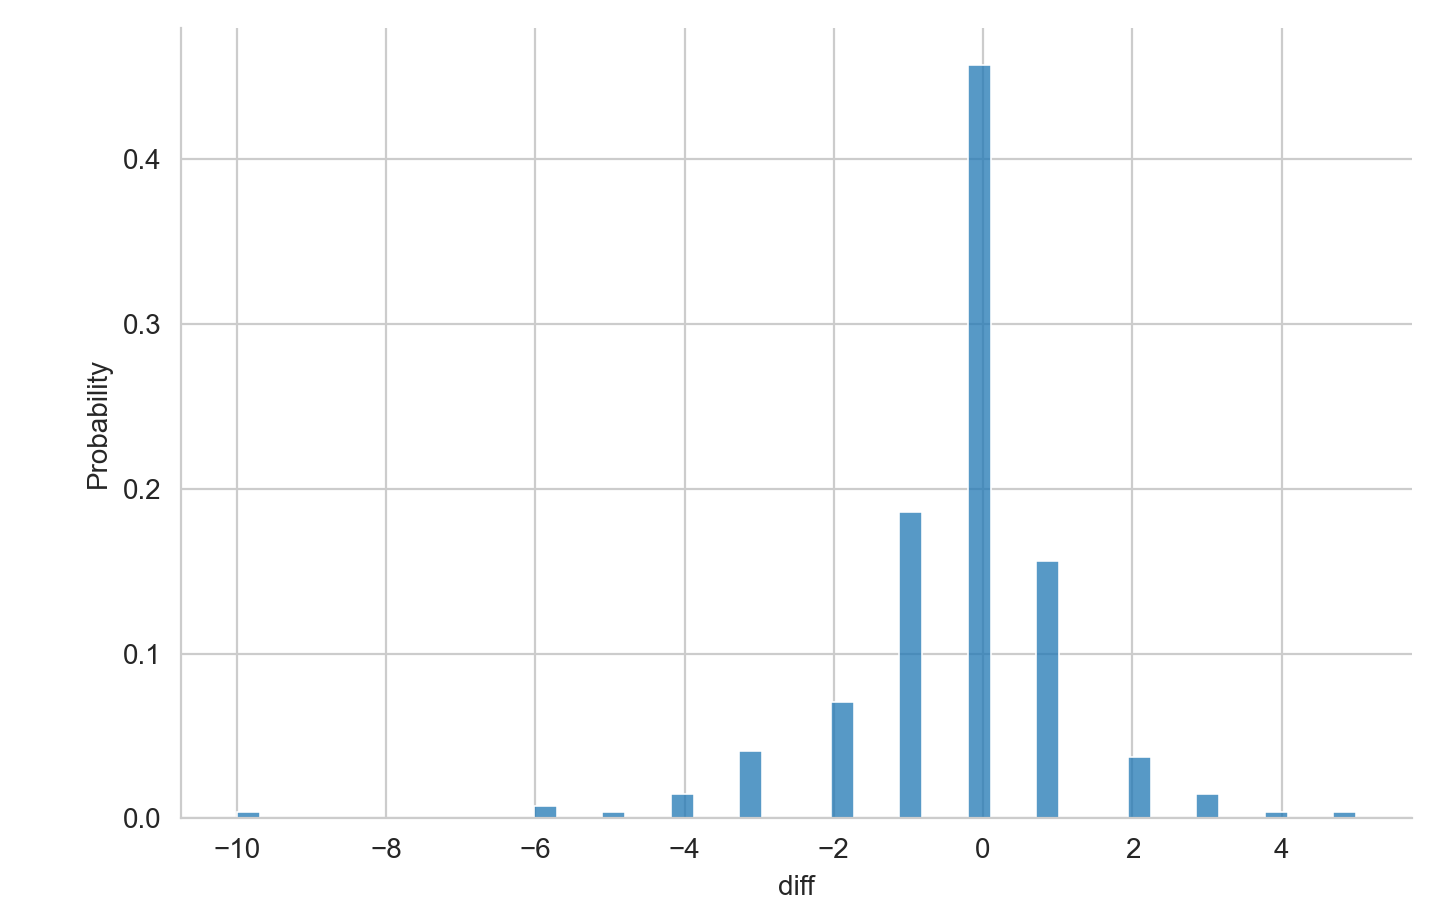

In [356]:
sns.displot(comp_binds['diff'], stat='probability')

In [361]:
merged = comp.merge(comp_binds, on='email', suffixes=('_quotes','_binds'))

In [363]:
merged['bind_quote_ratio_grpA'] = merged.small_retail_treatment_binds_grpA/merged.small_retail_treatment_quotes_grpA
merged['bind_quote_ratio_grpB'] = merged.small_retail_treatment_binds_grpB/merged.small_retail_treatment_quotes_grpB

In [365]:
merged['bind_quote_ratio_diff'] = merged.bind_quote_ratio_grpB - merged.bind_quote_ratio_grpA

In [367]:
merged.sort_values('bind_quote_ratio_diff', ascending=False)

email  small_retail_treatment_quotes_grpA  \
146         dbuetzer@ipoklahoma.com                                 1.0   
165        craig@claryinsurance.com                                 1.0   
160         dauxilien@hkelleher.com                                 1.0   
166  jteske@sweetgrassinsurance.com                                 1.0   
168     kkreiser@heistinsurance.com                                 1.0   
..                              ...                                 ...   
96                 angel@lef.agency                                 2.0   
230        abcinsuranceus@gmail.com                                 1.0   
77                  mrampy@twfg.com                                 3.0   
73        faigy@gottliebsagency.com                                 2.0   
134     sheila@shughesinsurance.com                                 1.0   

     small_retail_treatment_quotes_grpB  diff_quotes  \
146                                 1.0          0.0   
165                                 1.0          0.0   
160                                 1.0          0.0   
166                                 1.0          0.0   
168                                 1.0          0.0   
..                                  ...          ...   
96                                  1.0         -1.0   
230                                 2.0          1.0   
77                                  2.0         -1.0   
73                                  1.0         -1.0   
134                                 1.0          0.0   

     small_retail_treatment_binds_grpA  small_retail_treatment_binds_grpB  \
146                                0.0                                1.0   
165                                0.0                                1.0   
160                                0.0                                1.0   
166                                0.0                                1.0   
168                                0.0                                1.0   
..                                 ...                                ...   
96                                 2.0                                0.0   
230                                1.0                                0.0   
77                                 3.0                                0.0   
73                                 2.0                                0.0   
134                                1.0                                0.0   

     diff_binds  bind_quote_ratio_grpA  bind_quote_ratio_grpB  \
146         1.0                    0.0                    1.0   
165         1.0                    0.0                    1.0   
160         1.0                    0.0                    1.0   
166         1.0                    0.0                    1.0   
168         1.0                    0.0                    1.0   
..          ...                    ...                    ...   
96         -2.0                    1.0                    0.0   
230        -1.0                    1.0                    0.0   
77         -3.0                    1.0                    0.0   
73         -2.0                    1.0                    0.0   
134        -1.0                    1.0                    0.0   

     bind_quote_ratio_diff  
146                    1.0  
165                    1.0  
160                    1.0  
166                    1.0  
168                    1.0  
..                     ...  
96                    -1.0  
230                   -1.0  
77                    -1.0  
73                    -1.0  
134                   -1.0  

[269 rows x 10 columns]

<IPython.core.display.Javascript object>


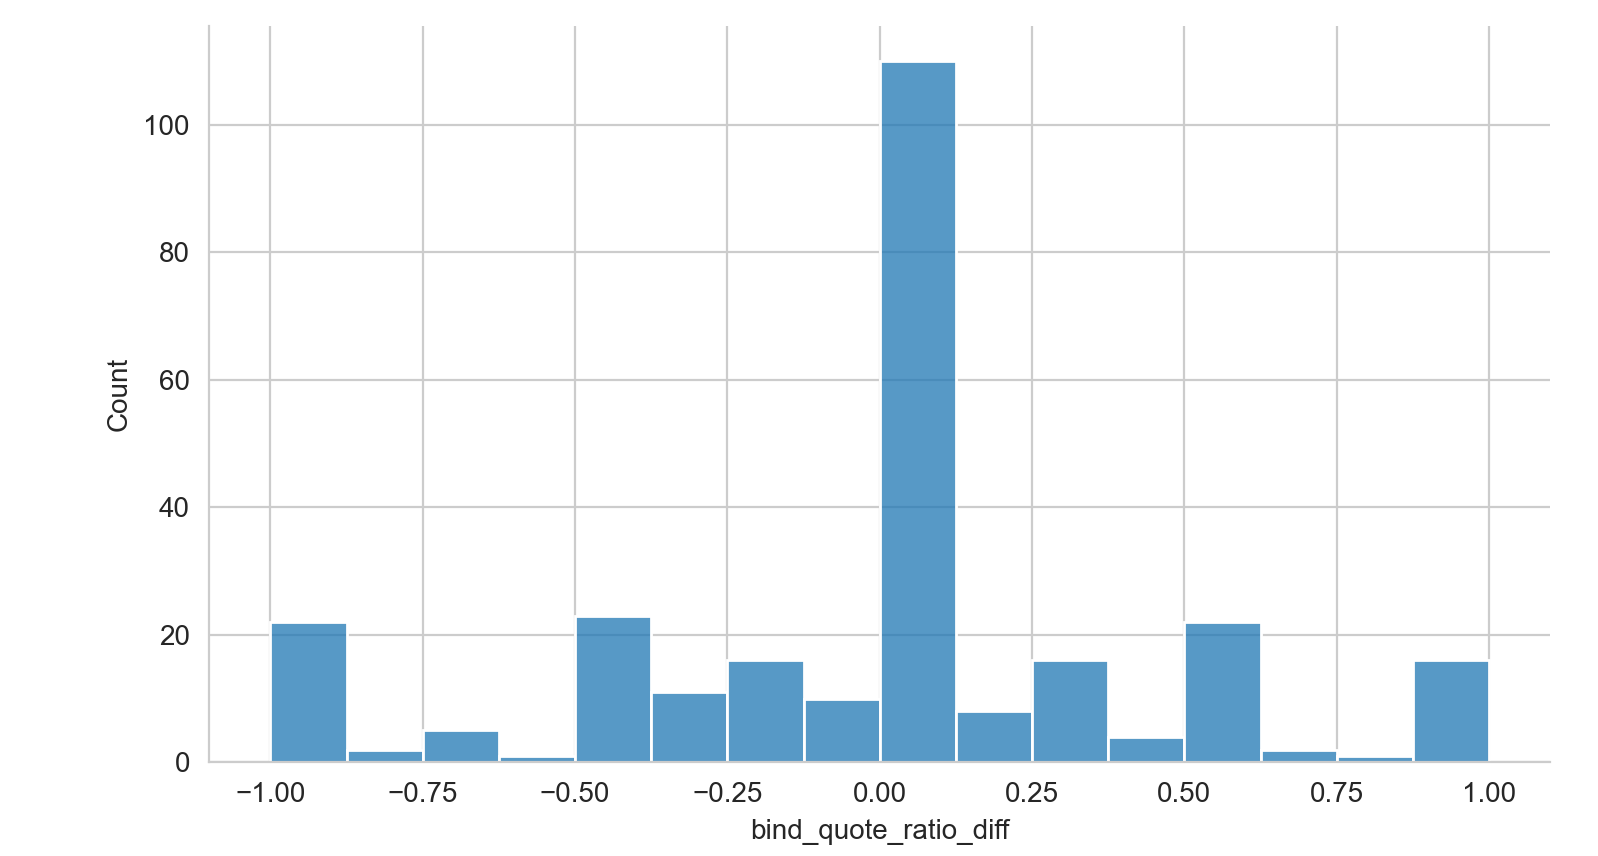

In [368]:
sns.displot(merged.bind_quote_ratio_diff)

In [372]:
merged.sort_values('diff_quotes')

email  \
0               jaclyn.ottman@iscential.com   
1                  crescent@crescentins.com   
2         andrew@insurance4contractors.info   
3    andrew.wolfe@pacificcrestinsurance.com   
4                     info@no1insurance.com   
..                                      ...   
264                     john@kevinleeco.com   
265       stephen@texasinsuranceoptions.net   
266             ben@primepointinsurance.com   
267             edemaria@abilityservice.com   
268                        phi@orchidag.com   

     small_retail_treatment_quotes_grpA  small_retail_treatment_quotes_grpB  \
0                                  14.0                                 2.0   
1                                  17.0                                 6.0   
2                                  15.0                                 6.0   
3                                   9.0                                 2.0   
4                                  15.0                                 9.0   
..                                  ...                                 ...   
264                                 1.0                                 6.0   
265                                11.0                                16.0   
266                                 4.0                                 9.0   
267                                 6.0                                12.0   
268                                 4.0                                21.0   

     diff_quotes  small_retail_treatment_binds_grpA  \
0          -12.0                                3.0   
1          -11.0                               14.0   
2           -9.0                                0.0   
3           -7.0                                3.0   
4           -6.0                                8.0   
..           ...                                ...   
264          5.0                                0.0   
265          5.0                                7.0   
266          5.0                                2.0   
267          6.0                                2.0   
268         17.0                                1.0   

     small_retail_treatment_binds_grpB  diff_binds  bind_quote_ratio_grpA  \
0                                  0.0        -3.0               0.214286   
1                                  4.0       -10.0               0.823529   
2                                  0.0         0.0               0.000000   
3                                  0.0        -3.0               0.333333   
4                                  4.0        -4.0               0.533333   
..                                 ...         ...                    ...   
264                                0.0         0.0               0.000000   
265                                9.0         2.0               0.636364   
266                                5.0         3.0               0.500000   
267                                1.0        -1.0               0.333333   
268                                0.0        -1.0               0.250000   

     bind_quote_ratio_grpB  bind_quote_ratio_diff  
0                 0.000000              -0.214286  
1                 0.666667              -0.156863  
2                 0.000000               0.000000  
3                 0.000000              -0.333333  
4                 0.444444              -0.088889  
..                     ...                    ...  
264               0.000000               0.000000  
265               0.562500              -0.073864  
266               0.555556               0.055556  
267               0.083333              -0.250000  
268               0.000000              -0.250000  

[269 rows x 10 columns]

In [369]:
merged[merged.bind_quote_ratio_diff<-.5]

email  \
9                          sang@aclins.com   
33                  victor@viprealtyny.com   
36                 smoltino@narrowsins.com   
73               faigy@gottliebsagency.com   
77                         mrampy@twfg.com   
96                        angel@lef.agency   
101                    ktroxler@rivins.com   
108               jagdeep@jsinghagency.com   
112                      wbeard@mrgllc.net   
113                 ann@americanagency.com   
117        rmorgan@innovativeinsurance.org   
119               andy@bassingeragency.com   
120  allison.ownbey@riversideinsagency.com   
121              russ@wannamakeragency.com   
123                     david@yesbaker.com   
134            sheila@shughesinsurance.com   
143           eric@dandeinsurancegroup.com   
152            maryannfleming@tysonins.com   
154                 blake@insurebeacon.com   
179                    matt@aliaagents.com   
185             bethl@stewartinsagency.com   
209                 jandriassian@gmail.com   
230               abcinsuranceus@gmail.com   
235     cindyg@aydletteinsuranceagency.com   
238            carlisleins@carlisleins.com   
243                 bcoley@suggsagency.com   
244                      dingbaf@yahoo.com   
246               raymond@rngfinancial.net   
250                     sue@kevinleeco.com   
259     roberthill@innovativeinsurance.org   

     small_retail_treatment_quotes_grpA  small_retail_treatment_quotes_grpB  \
9                                   8.0                                 3.0   
33                                  5.0                                 2.0   
36                                  4.0                                 1.0   
73                                  2.0                                 1.0   
77                                  3.0                                 2.0   
96                                  2.0                                 1.0   
101                                 5.0                                 4.0   
108                                 5.0                                 4.0   
112                                 1.0                                 1.0   
113                                 1.0                                 1.0   
117                                 1.0                                 1.0   
119                                 1.0                                 1.0   
120                                 1.0                                 1.0   
121                                 1.0                                 1.0   
123                                 2.0                                 2.0   
134                                 1.0                                 1.0   
143                                 1.0                                 1.0   
152                                 1.0                                 1.0   
154                                 1.0                                 1.0   
179                                 1.0                                 1.0   
185                                 3.0                                 3.0   
209                                 1.0                                 2.0   
230                                 1.0                                 2.0   
235                                 1.0                                 3.0   
238                                 1.0                                 3.0   
243                                 1.0                                 3.0   
244                                 1.0                                 3.0   
246                                 1.0                                 4.0   
250                                 2.0                                 5.0   
259                                 1.0                                 5.0   

     diff_quotes  small_retail_treatment_binds_grpA  \
9           -5.0                                6.0   
33          -3.0                                5.

In [385]:
merged.sort_values(['bind_quote_ratio_diff','diff_quotes'])[
    ['email', 'diff_quotes', 'diff_binds', 'bind_quote_ratio_diff']].head(35)

email  diff_quotes  diff_binds  \
33                  victor@viprealtyny.com         -3.0        -5.0   
73               faigy@gottliebsagency.com         -1.0        -2.0   
77                         mrampy@twfg.com         -1.0        -3.0   
96                        angel@lef.agency         -1.0        -2.0   
112                      wbeard@mrgllc.net          0.0        -1.0   
113                 ann@americanagency.com          0.0        -1.0   
117        rmorgan@innovativeinsurance.org          0.0        -1.0   
119               andy@bassingeragency.com          0.0        -1.0   
120  allison.ownbey@riversideinsagency.com          0.0        -1.0   
121              russ@wannamakeragency.com          0.0        -1.0   
123                     david@yesbaker.com          0.0        -2.0   
134            sheila@shughesinsurance.com          0.0        -1.0   
143           eric@dandeinsurancegroup.com          0.0        -1.0   
152            maryannfleming@tysonins.com          0.0        -1.0   
154                 blake@insurebeacon.com          0.0        -1.0   
179                    matt@aliaagents.com          0.0        -1.0   
209                 jandriassian@gmail.com          1.0        -1.0   
230               abcinsuranceus@gmail.com          1.0        -1.0   
235     cindyg@aydletteinsuranceagency.com          2.0        -1.0   
243                 bcoley@suggsagency.com          2.0        -1.0   
246               raymond@rngfinancial.net          3.0        -1.0   
250                     sue@kevinleeco.com          3.0        -2.0   
101                    ktroxler@rivins.com         -1.0        -4.0   
259     roberthill@innovativeinsurance.org          4.0         0.0   
9                          sang@aclins.com         -5.0        -6.0   
36                 smoltino@narrowsins.com         -3.0        -3.0   
238            carlisleins@carlisleins.com          2.0         0.0   
244                      dingbaf@yahoo.com          2.0         0.0   
185             bethl@stewartinsagency.com          0.0        -2.0   
108               jagdeep@jsinghagency.com         -1.0        -3.0   
7                      todd@fryintegra.com         -5.0        -3.0   
8                 insulandagency@gmail.com         -5.0        -6.0   
12     tammy@lamberthinsuranceservices.com         -5.0        -3.0   
26                      jlac7775@gmail.com         -3.0        -2.0   
31                 cerissa@bayouinsure.com         -3.0        -2.0   

     bind_quote_ratio_diff  
33               -1.000000  
73               -1.000000  
77               -1.000000  
96               -1.000000  
112              -1.000000  
113              -1.000000  
117              -1.000000  
119              -1.000000  
120              -1.000000  
121              -1.000000  
123              -1.000000  
134              -1.000000  
143              -1.000000  
152              -1.000000  
154              -1.000000  
179              -1.000000  
209              -1.000000  
230              -1.000000  
235              -1.000000  
243              -1.000000  
246              -1.000000  
250              -1.000000  
101              -0.800000  
259              -0.800000  
9                -0.750000  
36               -0.750000  
238              -0.666667  
244              -0.666667  
185              -0.666667  
108              -0.600000  
7                -0.500000  
8                -0.500000  
12               -0.500000  
26               -0.500000  
31               -0.500000

In [373]:
merged[merged.email.str.contains('jay')]

email  small_retail_treatment_quotes_grpA  \
28   jay.kibbe@verifyins.net                                20.0   
197     jaylee@grandworld.us                                 3.0   

     small_retail_treatment_quotes_grpB  diff_quotes  \
28                                 17.0         -3.0   
197                                 4.0          1.0   

     small_retail_treatment_binds_grpA  small_retail_treatment_binds_grpB  \
28                                11.0                               11.0   
197                                2.0                                2.0   

     diff_binds  bind_quote_ratio_grpA  bind_quote_ratio_grpB  \
28          0.0               0.550000               0.647059   
197         0.0               0.666667               0.500000   

     bind_quote_ratio_diff  
28                0.097059  
197              -0.166667

#### Significance test of bootstrapped difference in mean quotes, pre vs post experiment

- For a time window before and after experiment start (say 2 months), bootstrap a distribution (10k data points) of the difference in mean # of quotes/week/user between treatment and control groups.  
- Compare the pre- and post- distributions with a t-test to determine a signficant change in quote/bind rate due to rewards emails

##### Pre-experiment, small retail quotes

In [152]:
# pre_exp = df[(df.exp_ts_delta>='-63 days') & (df.exp_ts_delta<'0 days')].copy()
print(pre_exp.email.nunique())
print(pre_exp[['email', 'week', 'small_retail_treatment_quotes']].dropna().email.nunique())
print(pre_exp[['email', 'week', 'small_retail_control_quotes']].dropna().email.nunique())

1122
536
513


In [278]:
def calc_bootstrapped_sample_mean(df, segment_group_metric_col_name, n_days_per_period=7) -> float:
    # get data for specific segment_group
    group = df[['email', 'week', segment_group_metric_col_name]].dropna()
    # bootstrap sample of users
    bootstrapped_email_sample = pd.Series(
        group.email.unique()).sample(frac=1, replace=True
                                     )
    # calculate number of periods in sample
    n_periods = (group.week.max() - group.week.min()).days/n_days_per_period
    # calculate mean of metric for bootstrapped sample
    bootstrapped_sample_mean = pd.DataFrame(bootstrapped_email_sample, columns=['email']).merge(
        (group.groupby('email')[
         segment_group_metric_col_name].sum()/n_periods).reset_index()
    ).mean()[segment_group_metric_col_name]
    return bootstrapped_sample_mean

In [154]:
pre_exp_small_retail_mean_diff_dist = []
for i in range(3000):
    diff = calc_bootstrapped_sample_mean(pre_exp, 'small_retail_treatment_quotes', 7) - \
    calc_bootstrapped_sample_mean(pre_exp, 'small_retail_control_quotes', 7)
    pre_exp_small_retail_mean_diff_dist.append(diff)

##### Post-experiment, small retail

In [155]:
# post_exp = df[(df.exp_ts_delta>='0 days') & (df.exp_ts_delta<='63 days')].copy()
print(post_exp.email.nunique())
print(post_exp[['email', 'week', 'small_retail_treatment_quotes']].dropna().email.nunique())
print(post_exp[['email', 'week', 'small_retail_control_quotes']].dropna().email.nunique())

846
432
362


In [61]:
post_exp[['email', 'week', 'small_retail_control_quotes']]

email       week  \
3                 insurehoustontx@gmail.com 2021-06-21   
4                   jay.kibbe@verifyins.net 2021-06-21   
16                 skhatri@farmersagent.com 2021-05-24   
17                  jay.kibbe@verifyins.net 2021-06-07   
18             acordplusinsurance@gmail.com 2021-06-21   
...                                     ...        ...   
4619                martin@bigfootbinds.com 2021-07-19   
4620  mitchell.pluskalowski@rtspecialty.com 2021-07-19   
4621                      mlevy@morstan.com 2021-07-19   
4622                    mmazzei@morstan.com 2021-07-19   
4623                    msenitt@morstan.com 2021-07-19   

      small_retail_control_quotes  
3                             NaN  
4                             NaN  
16                            NaN  
17                            NaN  
18                            NaN  
...                           ...  
4619                          NaN  
4620                          NaN  
4621                          NaN  
4622                          NaN  
4623                          NaN  

[1699 rows x 3 columns]

In [156]:
post_exp_small_retail_mean_diff_dist = []
for i in range(3000):
    diff = calc_bootstrapped_sample_mean(post_exp, 'small_retail_treatment_quotes', 7) - \
    calc_bootstrapped_sample_mean(post_exp, 'small_retail_control_quotes', 7)
    post_exp_small_retail_mean_diff_dist.append(diff)

##### Compare pre & post distributions

In [157]:
from statsmodels.stats.weightstats import ttest_ind

In [159]:
ttest_ind(post_exp_small_retail_mean_diff_dist,
          pre_exp_small_retail_mean_diff_dist, alternative='larger', value=0.01)

(1.9524194985583936, 0.025467437923680624, 5998.0)

Translate to significance of increase in quotes  
Value of quote: 
average quote value * bind_rate*(1+lift) - mean cost of reward  
average quote value * bind_rate

In [111]:
def calc_mean_quotes_week(df, segment_group_metric_col_name, n_days_per_period=7):
    return (df.groupby('email')[segment_group_metric_col_name].sum() /
            ((df.week.max() - df.week.min()).days/n_days_per_period)).mean()

Difference in treatment vs control, pre and post exp

In [160]:
(calc_mean_quotes_week(pre_exp, 'small_retail_treatment_quotes') -
    calc_mean_quotes_week(pre_exp, 'small_retail_control_quotes')
 ) / calc_mean_quotes_week(pre_exp, 'small_retail_control_quotes')

0.1526785714285715

In [161]:
(calc_mean_quotes_week(post_exp, 'small_retail_treatment_quotes') -
    calc_mean_quotes_week(post_exp, 'small_retail_control_quotes')
 ) / calc_mean_quotes_week(post_exp, 'small_retail_control_quotes')

0.35560859188544147

In [147]:
calc_mean_quotes_week(pre_exp, 'small_retail_treatment_quotes') -\
    calc_mean_quotes_week(pre_exp, 'small_retail_control_quotes')

0.026088169642857123

In [148]:
calc_mean_quotes_week(post_exp, 'small_retail_treatment_quotes') -\
    calc_mean_quotes_week(post_exp, 'small_retail_control_quotes')

0.04403073286052009

In [162]:
bdf = pd.concat(
    [pd.DataFrame({'data': pre_exp_small_retail_mean_diff_dist, 'group': 'pre'}),
     pd.DataFrame({'data': post_exp_small_retail_mean_diff_dist, 'group': 'post'})]
)

<IPython.core.display.Javascript object>


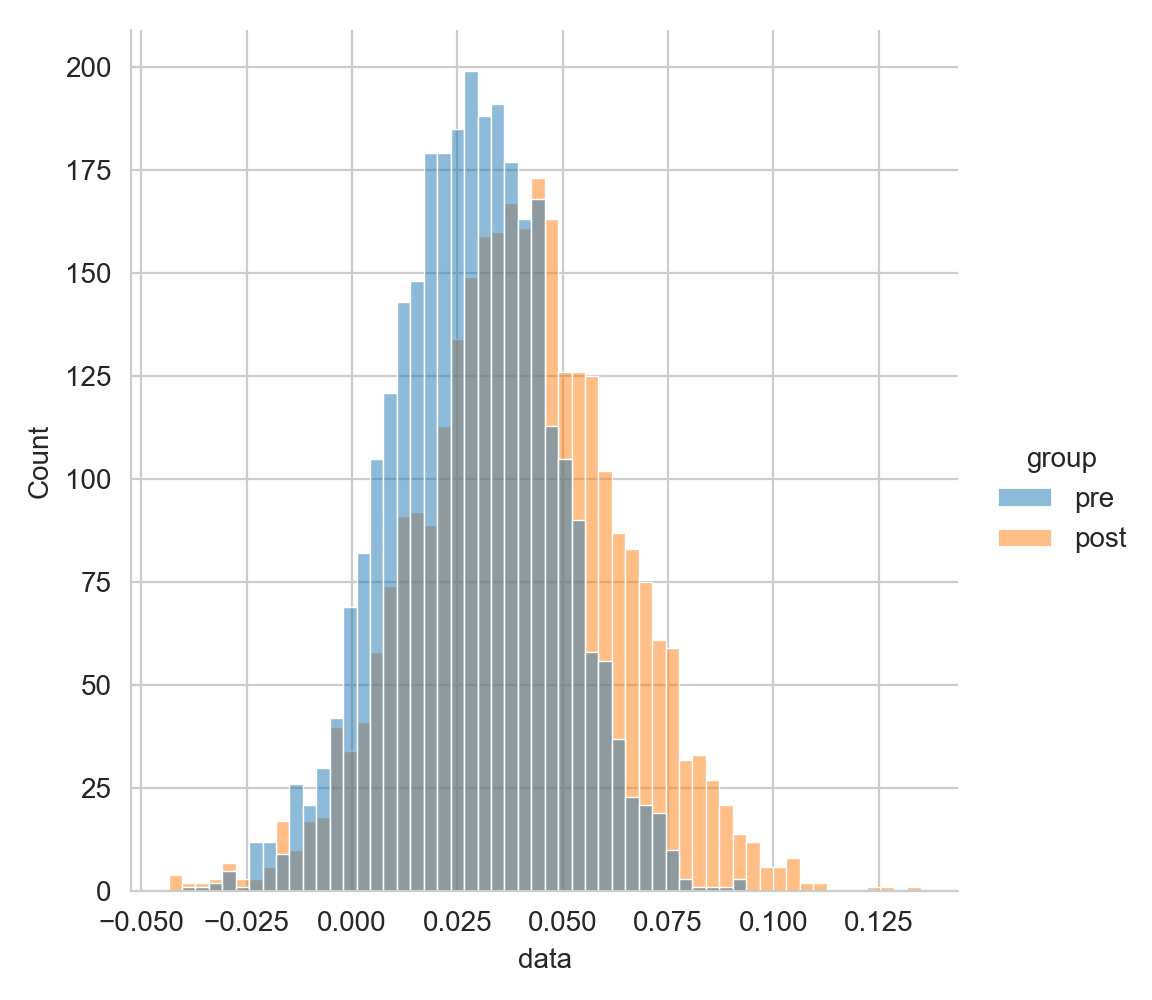

In [163]:
sns.displot(data=bdf, x='data',hue='group')

##### Confidence interval

In [281]:
from statistics import NormalDist

def confidence_interval(data, confidence=0.95):
  dist = NormalDist.from_samples(data)
  z = NormalDist().inv_cdf((1 + confidence) / 2.)
  h = dist.stdev * z / ((len(data) - 1) ** .5)
  return [dist.mean - h, dist.mean, dist.mean + h]

def create_bootstrap_interval(alpha, data):
    """
    Calculates the confidence interval around the mean of the data
    using a bootstrap method
    Parameters
    ----------
    alpha : float
            Probability that an rv will be drawn from the returned range.
            Each value should be in the range [0, 1].
    data : np.array
        The distribution of data to compute an interval on.
    Returns
    -------
    np.array
        end-points of range that contain ``100 * alpha %`` of the data's
        possible values.
    """
    bootstrap_mean_list = []
    np.random.seed(seed=0)
    for _ in range(10000):
        bootstrap_mean = np.random.choice(data, len(data)).mean()
        bootstrap_mean_list.append(bootstrap_mean)
    lower_quantile = (1-alpha)/2
    upper_quantile = 1-lower_quantile
    lower, upper = np.quantile(bootstrap_mean_list, [lower_quantile, upper_quantile])
    return lower, data.mean(), upper

By difference in quotes/YEAR between treatment & control, pre vs post experiment 
- Pre: 1.47 +/- .04
- Post: 2.07 +/- .04
- 0.6 +/- .08 MORE quotes/YEAR/user due to rewards
- 41 +/- 7 % more quotes/year/user

Calc confidence intervals (2 methods)

In [164]:
# bdf.groupby('group')['data'].agg(lambda x: 52*np.array(confidence_interval(x)))
bdf[bdf.group=='pre']['data'].agg(lambda x: 52*np.array(confidence_interval(x)))

array([1.44134393, 1.47724459, 1.51314526])

In [165]:
# bdf.groupby('group')['data'].agg(lambda x: 52*np.array(confidence_interval(x)))
bdf[bdf.group=='pre']['data'].agg(lambda x: 52*np.array(create_bootstrap_interval(.95,x)))

array([1.44035079, 1.51346917])

In [166]:
# bdf.groupby('group')['data'].agg(lambda x: 52*np.array(confidence_interval(x)))
bdf[bdf.group=='post']['data'].agg(lambda x: 52*np.array(confidence_interval(x)))

array([2.00958725, 2.05455253, 2.09951781])

In [167]:
# bdf.groupby('group')['data'].agg(lambda x: 52*np.array(confidence_interval(x)))
bdf[bdf.group=='post']['data'].agg(lambda x: 52*np.array(create_bootstrap_interval(.95, x)))

array([2.00943707, 2.09978815])

Increase in difference

In [178]:
calc_mean_quotes_week(pre_exp, 'small_retail_control_quotes')*52

6.4884135472370765

In [179]:
calc_mean_quotes_week(pre_exp, 'small_retail_treatment_quotes')*52

7.479055258467024

In [180]:
1/6.5

0.15384615384615385

In [177]:
.019/.125

0.152

In [176]:
calc_mean_quotes_week(pre_exp, 'small_retail_treatment_quotes') - calc_mean_quotes_week(pre_exp, 'small_retail_control_quotes')

0.01905080213903744

In [181]:
52*(calc_mean_quotes_week(post_exp, 'small_retail_treatment_quotes') - calc_mean_quotes_week(post_exp, 'small_retail_control_quotes'))

2.2895981087470445

In [ ]:
(s1/nquotes + s2/nquotes) = 1/nquotes[(s1 + s2)/2]

In [183]:
2.28/8.72

0.2614678899082568

In [182]:
52*(calc_mean_quotes_week(post_exp, 'small_retail_treatment_quotes'))

8.728132387706856

In [175]:
.044/.124

0.3548387096774193

In [173]:
calc_mean_quotes_week(post_exp, 'small_retail_treatment_quotes')

0.16784869976359337

In [168]:
bdf[bdf.group == 'pre']['data'].agg(lambda x: confidence_interval(
    x))/calc_mean_quotes_week(pre_exp, 'small_retail_control_quotes')

array([0.22214119, 0.22767423, 0.23320728])

In [169]:
bdf[bdf.group == 'post']['data'].agg(lambda x: confidence_interval(
    x))/calc_mean_quotes_week(post_exp, 'small_retail_control_quotes')

array([0.31211875, 0.31910252, 0.3260863 ])

##### Pre-experiment, small retail binds

In [264]:
pre_exp_small_retail_mean_diff_dist_binds = []
for i in range(10000):
    diff = calc_bootstrapped_sample_mean(pre_exp, 'small_retail_treatment_binds', 7) - \
    calc_bootstrapped_sample_mean(pre_exp, 'small_retail_control_binds', 7)
    pre_exp_small_retail_mean_diff_dist_binds.append(diff)

##### Post-experiment, small retail binds

In [265]:
post_exp_small_retail_mean_diff_dist_binds = []
for i in range(10000):
    diff = calc_bootstrapped_sample_mean(post_exp, 'small_retail_treatment_binds', 7) - \
    calc_bootstrapped_sample_mean(post_exp, 'small_retail_control_binds', 7)
    post_exp_small_retail_mean_diff_dist_binds.append(diff)

##### Compare pre & post distributions

In [266]:
ttest_ind(post_exp_small_retail_mean_diff_dist_binds,
          pre_exp_small_retail_mean_diff_dist_binds, alternative='larger', value=0.0)

(-11.621113474855646, 1.0, 19998.0)

In [267]:
bdf_binds = pd.concat(
    [pd.DataFrame({'data': pre_exp_small_retail_mean_diff_dist_binds, 'group': 'pre'}),
     pd.DataFrame({'data': post_exp_small_retail_mean_diff_dist_binds, 'group': 'post'})]
)

<IPython.core.display.Javascript object>


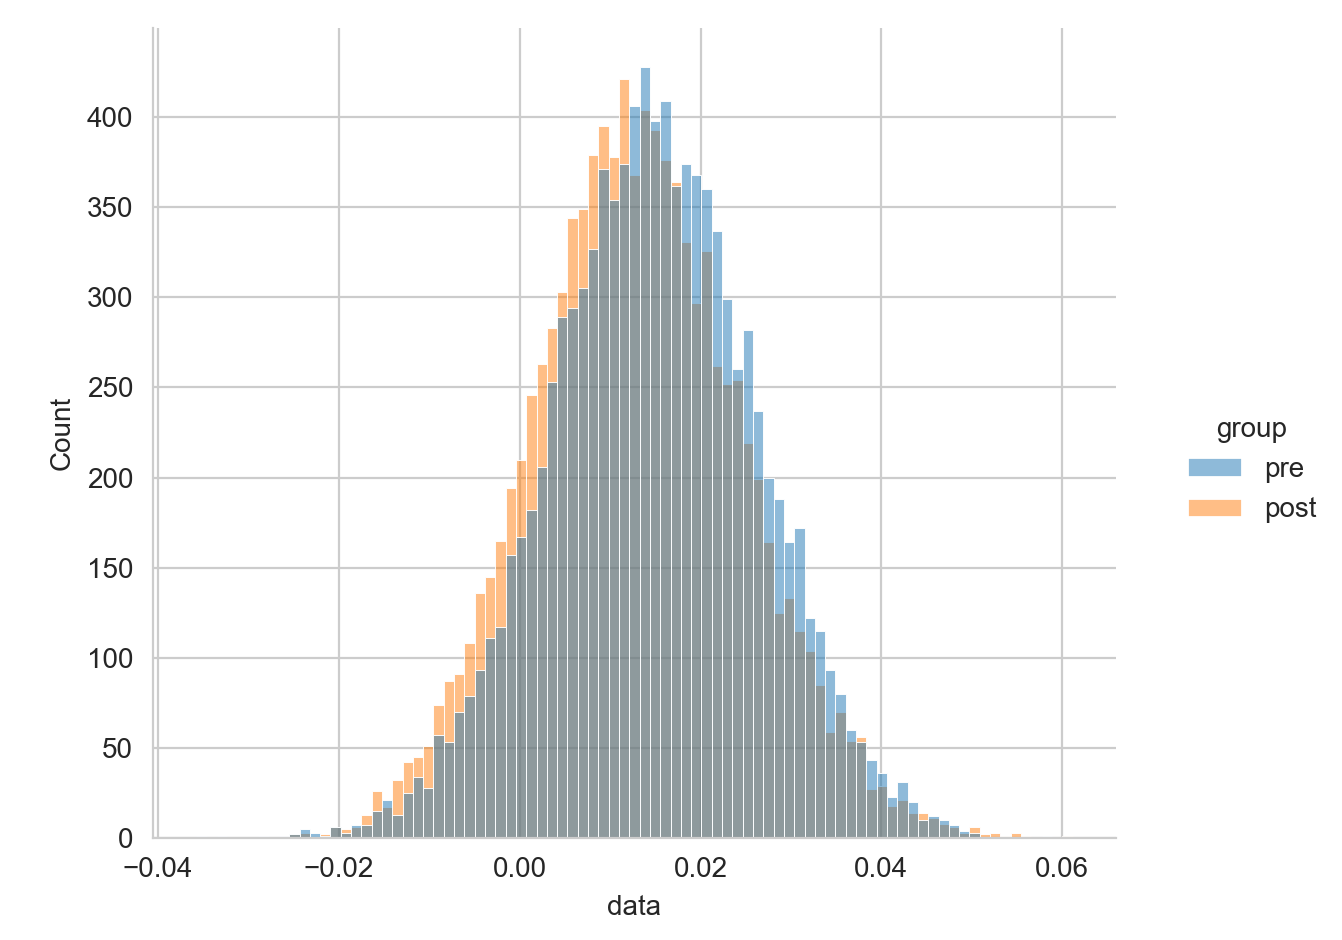

In [268]:
sns.displot(data=bdf_binds, x='data',hue='group')

##### Confidence interval

By difference in binds/YEAR between treatment & control, pre vs post experiment  
- .23 +/- .03 MORE binds/YEAR/user due to rewards  
- .23 * 29000 * 2000 - 1.2 * 29000 * 5 = 13 million  
- adjust this to remove opted out prouducres and correct average value of rewards (maybe closer to 7?)
- ideally release this without marketing blasts screwing up measurements

In [139]:
.23 * 5000 * 2700 - 1.2 * 5000 * 10

3045000.0

In [141]:
1.2 * 10000 * 5

60000.0

In [133]:
bdf_binds[bdf_binds.group=='pre']['data'].agg(lambda x: 52*np.array(confidence_interval(x)))

array([0.75617434, 0.77789672, 0.7996191 ])

In [134]:
bdf_binds[bdf_binds.group=='post']['data'].agg(lambda x: 52*np.array(confidence_interval(x)))

array([0.64982992, 0.67206616, 0.69430239])

In [98]:
bdf_binds[bdf_binds.group == 'post']['data'].agg(lambda x: 52*np.array(confidence_interval(
    x))) - bdf_binds[bdf_binds.group == 'pre']['data'].agg(lambda x: 52*np.array(confidence_interval(x)))[::-1]

array([0.20009128, 0.22767747, 0.25526365])

## Determine Experiment parameters

Rather than defining our main test metric as a conversion fraction (as is done [here](https://knowledge.attuneanalytics.com/post/posts/calc-treatment-effect.kp)), we define the rate as quotes/binds per week. We further assume a Poisson model for the rate, and use this [hypothesis test from statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.stats.rates.test_poisson_2indep.html#statsmodels.stats.rates.test_poisson_2indep) to determine the number of weeks needed to run our experiment, and the minimum rate change we will be able to detect.

In [639]:
# Get producer code stats for the last 6 months
pcstats_df.binds.sum()
pcstats_df.quotes.sum()
pcstats_df.n_users.sum()

4704

14752

11498

### Quote Rate

Iterate over ranges of test group sample size (`user_frac`), number of weeks and rate change to find experimental parameters that allow for detecting a significant (`p-val <= 0.5`) rate change.

####  Poisson significance test

In [262]:
import statsmodels.stats.rates as sr

In [263]:
# Small retail
def calc_current_significance(treatment_n_users, control_n_users,
                              treatment_n_events, control_n_events, n_weeks):
    control_exposure = control_n_users * n_weeks
    treatment_exposure = treatment_n_users * n_weeks

    treatment_rate = (treatment_n_events/treatment_exposure)
    control_rate = (control_n_events/control_exposure)
    rate_change = treatment_rate/control_rate

    res = sr.test_poisson_2indep(control_n_events, control_exposure,
                                 treatment_n_events, treatment_exposure)

    print(
        f"treatment rate: {treatment_rate}, control_rate: {control_rate}, rate_change: {rate_change}")
    print(f"p-val: {res.pvalue}")

In [6]:
#quotes
n_treatment = 2312
n_control = 2974
n_quotes_treatment = 1636 #739
n_quotes_control = 1433 #536

In [7]:
calc_current_significance(n_treatment, n_control,
                          n_quotes_treatment, n_quotes_control, 5 + (5/7))

treatment rate: 0.12383217993079584, control_rate: 0.08432246133154002, rate_change: 1.4685550916725623
p-val: 1.1784429377243962e-26


In [7]:
#binds
calc_current_significance(1311, 1397, 119, 83, 5 + (5/7))

treatment rate: 0.026474701245868298, control_rate: 0.01732879980911477, rate_change: 1.5277862020163033
p-val: 0.0028281931675205544


#### Experimental Planning

In [698]:
import statsmodels.stats.rates as sr

# Assume stats from last 6 months will hold during experiment
n_binds = pcstats_df.binds.sum() 
n_quotes = pcstats_df.quotes.sum() 
n_users = pcstats_df.n_users.sum() 

for user_frac in [.30, .35, .40]:
    for n_weeks in range(4, 9):
        for rate_change in np.arange(1.06, 1.11, .01):

            time_frac = n_weeks/24
            control_count = n_quotes * user_frac * time_frac
            control_exposure = n_users * user_frac * n_weeks
            treatment_count = control_count * rate_change
            treatment_exposure = control_exposure

            res = sr.test_poisson_2indep(control_count, control_exposure,
                                   treatment_count, treatment_exposure)
            if res.pvalue<=.06:
                print(f"user_frac: {user_frac}, n_weeks: {n_weeks}, rate_change: {rate_change}")
                print(f"p-val: {res.pvalue}")
                print('-'*10)
                break

user_frac: 0.3, n_weeks: 4, rate_change: 1.11
p-val: 0.03971921132323805
----------
user_frac: 0.3, n_weeks: 5, rate_change: 1.09
p-val: 0.058715467796184244
----------
user_frac: 0.3, n_weeks: 6, rate_change: 1.09
p-val: 0.038383154760633344
----------
user_frac: 0.3, n_weeks: 7, rate_change: 1.08
p-val: 0.04627124706988136
----------
user_frac: 0.3, n_weeks: 8, rate_change: 1.08
p-val: 0.03312945247280075
----------
user_frac: 0.35, n_weeks: 4, rate_change: 1.1
p-val: 0.042939616514289604
----------
user_frac: 0.35, n_weeks: 5, rate_change: 1.09
p-val: 0.04117369665727978
----------
user_frac: 0.35, n_weeks: 6, rate_change: 1.08
p-val: 0.04627124706988136
----------
user_frac: 0.35, n_weeks: 7, rate_change: 1.07
p-val: 0.059017925765033924
----------
user_frac: 0.35, n_weeks: 8, rate_change: 1.07
p-val: 0.04354745446023156
----------
user_frac: 0.4, n_weeks: 4, rate_change: 1.09
p-val: 0.050901192280840245
----------
user_frac: 0.4, n_weeks: 5, rate_change: 1.08
p-val: 0.051789240445

### Bind Rate

In [699]:
# Assume stats from last 6 months will hold during experiment
n_binds = pcstats_df.binds.sum() 
n_quotes = pcstats_df.quotes.sum() 
n_users = pcstats_df.n_users.sum() 

for user_frac in [.30, .35, .40]:
    for n_weeks in range(4, 9):
        for rate_change in np.arange(1.13, 1.21, .01):

            time_frac = n_weeks/24
            control_count = n_binds * user_frac * time_frac
            control_exposure = n_users * user_frac * n_weeks
            treatment_count = control_count * rate_change
            treatment_exposure = control_exposure

            res = sr.test_poisson_2indep(control_count, control_exposure,
                                   treatment_count, treatment_exposure)
            if res.pvalue<=.06:
                print(f"user_frac: {user_frac}, n_weeks: {n_weeks}, rate_change: {rate_change}")
                print(f"p-val: {res.pvalue}")
                print('-'*10)
                break

user_frac: 0.3, n_weeks: 4, rate_change: 1.19
p-val: 0.04895075551516467
----------
user_frac: 0.3, n_weeks: 5, rate_change: 1.17
p-val: 0.04784324085564633
----------
user_frac: 0.3, n_weeks: 6, rate_change: 1.15
p-val: 0.054670971242415115
----------
user_frac: 0.3, n_weeks: 7, rate_change: 1.14
p-val: 0.052186047313418346
----------
user_frac: 0.3, n_weeks: 8, rate_change: 1.13
p-val: 0.05337044142427716
----------
user_frac: 0.35, n_weeks: 4, rate_change: 1.17
p-val: 0.05591956099387838
----------
user_frac: 0.35, n_weeks: 5, rate_change: 1.15
p-val: 0.058144514745977774
----------
user_frac: 0.35, n_weeks: 6, rate_change: 1.14
p-val: 0.05218604731341831
----------
user_frac: 0.35, n_weeks: 7, rate_change: 1.13
p-val: 0.05094630808828631
----------
user_frac: 0.35, n_weeks: 8, rate_change: 1.13
p-val: 0.03691500665273219
----------
user_frac: 0.4, n_weeks: 4, rate_change: 1.16
p-val: 0.05386942649306683
----------
user_frac: 0.4, n_weeks: 5, rate_change: 1.14
p-val: 0.0581184368959

## Random Sampling

In [655]:
merged_df.filter(regex='producer|quotes|binds|pc_|n_u|seg').drop_duplicates().head(2)

producer_code  quotes  binds    segment  pc_num_page_visits  n_users  \
0     SCOTT00001      97     26  wholesale                 5.0       93   
93   EVRISK00001      95     19  wholesale                 2.0        2   

    pc_mean_open_rate  pc_mean_click_rate  pc_mean_num_sent  
0            0.651672            0.064465         36.811111  
93           0.968232            0.019337        182.000000

Shown above are producer code level statistics we've calculated. We now want to sample a treatment and conrol group from this main test group such that both groups have similar aggregated statistics; specifically, for each group we'll take the mean of each statistic above and constrain that the difference between test groups should be within some tolerance, say 10%.

The first method we employ for sampling will be a brute force repeated random sampling: We will continue to draw samples until we find one in which all aggregated stats are similar.

### Sample wholesalers

Let's try this method on a small group of codes first, i.e. wholesalers (~100 codes).

In [757]:
# fraction of producers in AB test (treatment + control)
TEST_FRAC = 0.7
# make test group
test_sample = merged_df.filter(regex='producer|quotes|binds|pc_|n_u|seg').\
    drop_duplicates().sample(frac=TEST_FRAC)

In [758]:
def calc_sample_quality(df: pd.DataFrame, segment: str, random_state: int, tol=0.05):
    '''
    Randomly allocate codes in df into 2 test groups. Compute statistics of both groups
    and computerelative differences across groups, return a count of how many 
    differences are within a set tolerance.
    '''
    # make treatment group
    treatment_df = df[df.segment == segment].producer_code.\
        sample(frac=0.5, random_state=random_state)

    # calc stats for treatment/control
    treatment_stats = df[(df.segment == segment) & (df.producer_code.isin(treatment_df))].mean()
    control_stats = df[(df.segment == segment) & ~(df.producer_code.isin(treatment_df))].mean()

    # calc differences in stats btwn groups
    diffs = abs(treatment_stats - control_stats)/treatment_stats

    # find number of statistic difference within tolerancee
    n_valid = diffs.map(lambda x: True if x <= tol else False).sum()
    
    return n_valid, treatment_df, treatment_stats, control_stats, diffs

In [667]:
tic = time.time()

# set num iterations
random_states = np.random.randint(0, 100000, 5000)
n_valid = 0
num_iter = 0
max_n_valid = 0
best_sample = None

# continue sampling until we hit max iterations or find valid sample groups
while n_valid < 8 and num_iter <= len(random_states)-1:

    # Set tolerance here
    results = calc_sample_quality(test_sample,
                                  'wholesale',
                                  random_state=random_states[num_iter],
                                  tol=0.15)
    n_valid = results[0]
    if n_valid > max_n_valid:
        best_sample = results
    num_iter += 1
    if num_iter == len(random_states)-1:
        print('Max iterations reached!')

toc = time.time()
print(round(toc-tic, 1))

Max iterations reached!
19.3


In [759]:
print(f"Num stats within tolerance: {best_sample[0]}")
print()
print("Differences in stats between treatment/control groups:")
best_sample[-1]

Num stats within tolerance: 6

Differences in stats between treatment/control groups:


quotes                0.011685
binds                 0.060096
pc_num_page_visits    0.169131
n_users               0.050385
pc_mean_open_rate     0.001444
pc_mean_click_rate    0.004900
pc_mean_num_sent      0.069057
dtype: float64

After running the above a few times, we find samples that agree within 15% on 4 out of 8 of aggregated stats. We can possibly find more balanced groups by running longer and fiddling with tolerance, but this method is not as reliable as we'd like.

### Sample retail

In [685]:
tic = time.time()

# set num iterations
random_states = np.random.randint(0, 100000, 2500)
n_valid = 0
num_iter = 0
max_n_valid = 0
best_sample = None

# continue sampling until we hit max iterations or find valid sample groups
while n_valid < 8 and num_iter <= len(random_states)-1:

    # Set tolerance to 10%
    results = calc_sample_quality(test_sample,
                                  'small_retail',
                                  random_state=random_states[num_iter],
                                  tol=0.1)
    n_valid = results[0]
    if n_valid > max_n_valid:
        best_sample = results
    num_iter += 1
    if num_iter == len(random_states)-1:
        print('Max iterations reached!')

toc = time.time()
print(round(toc-tic, 1))

Max iterations reached!
12.3


In [686]:
print(f"Num stats within tolerance: {best_sample[0]}")
print()
print("Differences in stats between treatment/control groups:")
best_sample[-1]

Num stats within tolerance: 6

Differences in stats between treatment/control groups:


quotes                0.011685
binds                 0.060096
pc_num_page_visits    0.169131
n_users               0.050385
pc_mean_open_rate     0.001444
pc_mean_click_rate    0.004900
pc_mean_num_sent      0.069057
dtype: float64

We can do slightly better with retail producers, getting within 15% for all metrics and within 10% for 6 metrics.

## Semi-random sampling

A cumulative plot of the proportion (y-axis) of all producers (~3500) with vs total number of quotes (x-axis) in the last 6 months is shown below. Note a strong majority have ~20 quotes total, or ~3.3 quotes per month. The long tail includes producers (wholesalers) that have quoted up to 200 times. Randomly allocating these top producers into different test groups can lead to large differences between the groups, especially if the top 2 or 3 producers are placed in the same group.

To alleviate this, we take the following approach:  

- Sample "top" quoting producers separately from the rest ("bulk" producers)  
- When sampling top producers, use an algorithm that minimizes the difference between quotes/binds between treatment and control groups.  
- Sample bulk producers randomly, as usual.  
- Combine top and bulk groups at the end to arrive at a balanced treatment & control group.

In [25]:
test_df.head()

quotes  binds
producer_code               
TWFGD00001        198     87
SCOTT00001         97     26
EVRISK00001        95     19
REGRIG00001        84     30
BVGSERV00001       82     53

<IPython.core.display.Javascript object>


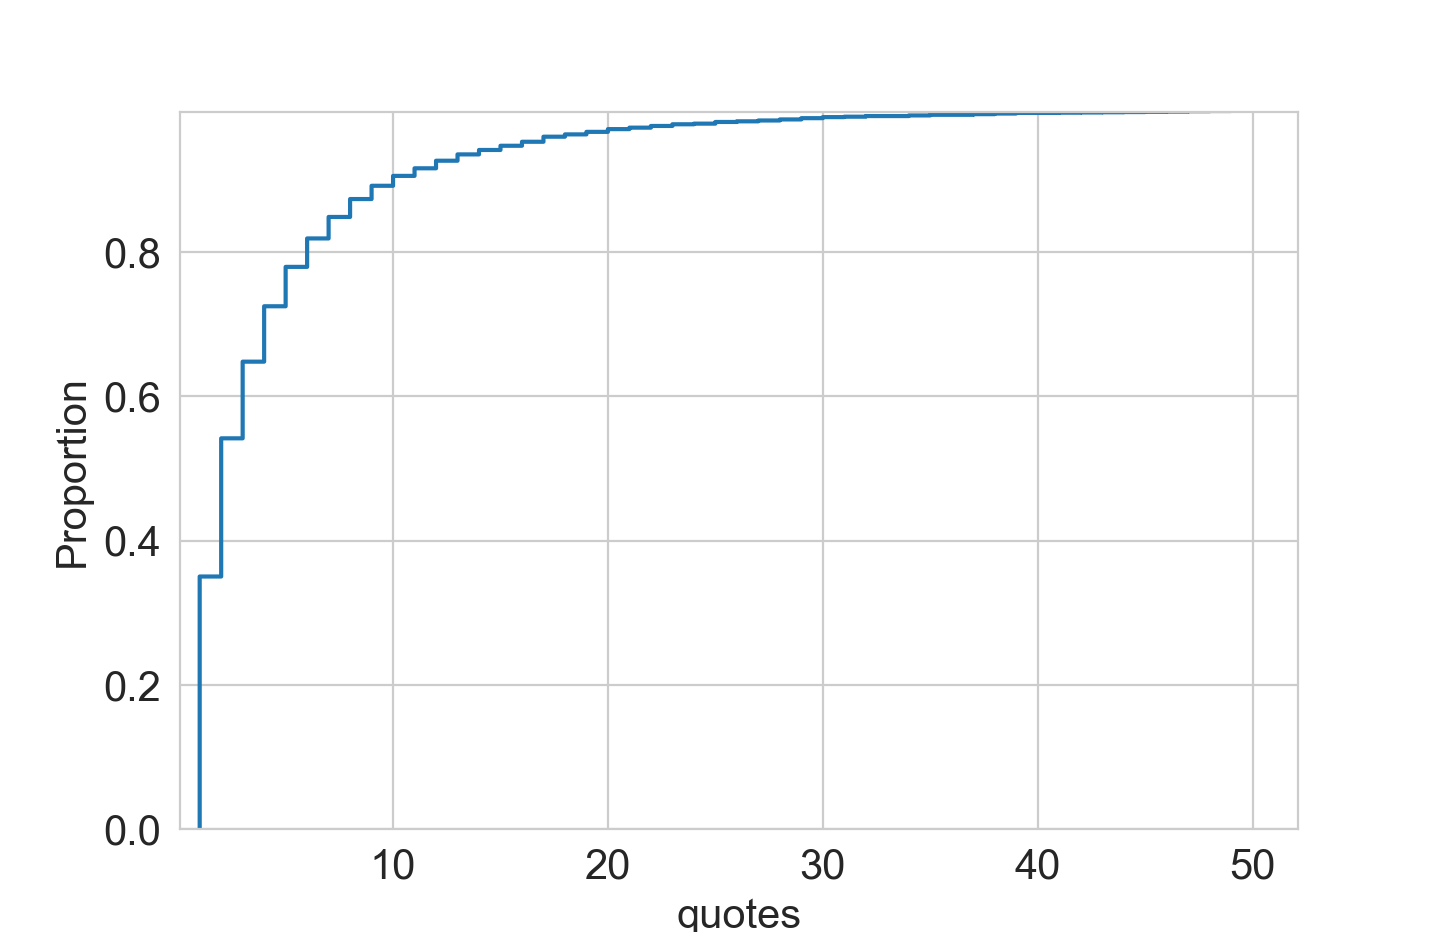

In [700]:
sns.ecdfplot(test_df.quotes);

### Define methods to allocate producer codes into balanced groups.

In [688]:
def pair(series: pd.Series):
    '''Split series into 2, return elementwise difference'''
    
    # input series should be sorted desc so this split is somewhat balanced
    a = series[::2]
    b = series[1::2]
    
    # get elementwise difference
    if a.size > b.size:
        return a, b, a.values[:-1]-b.values
    elif b.size < a.size:
        return a, b, a.values-b.values[:-1]
    
    return a, b, a.values-b.values


def shuffle(a, b, diff):
    '''
    Given two series a,b and their elementwise differences array `diff`,
    find an element in (a) that we can move to (b) to lower the total difference
    between both arrays. 

    Returns updated (a), updated (b) and the sorted a+b
    '''
    for i, d in enumerate(diff):
        # find index of element in a closest to d
        ind_min = abs(a-d).argmin()
        # set tolerance for closest element
        diff_min = abs(a-d).min() <= 5
        if diff_min:
            # get the producer code to move from a to b
            switch_ind = a.index[ind_min]
            # drop it from a
            new_a = a.drop(switch_ind)
            # make new index & value for insertion into b
            old_b_ind = b.index[i]
            new_b_ind = ','.join([old_b_ind, switch_ind])
            new_b_val = b[old_b_ind] + a[switch_ind]
            # drop old row from b
            new_b = b.drop(old_b_ind)
            # add new row into b
            new_b[new_b_ind] = new_b_val
            return new_a, new_b, new_a.append(new_b).sort_values(ascending=False)
    else:
        print('No suitable element swap found')
        return a.append(b).sort_values(ascending=False)


def get_topn(array, topn=20):
    return np.sort(array)[::-1][:topn]

### Define test, top and bulk groups

In [785]:
# Fraction of all producers in test group
TEST_FRAC = 0.7

# Get 
test_codes = pcstats_df.sample(frac=TEST_FRAC).set_index('producer_code')[
    'mean_scaled_stratified'].sort_values(ascending=False)

# Number of highest activity producers to separately into treatment/control
topN = round(test_codes.count() * .07)
top_codes = test_codes.head(topN)

bulk_codes = test_codes[~test_codes.index.isin(top_codes.index)]

print(f"Total # producers: {pcstats_df.producer_code.count()}")
print(f"Test Size: {test_codes.size}")
print(f"Top Producers Size: {top_codes.size}")
print(f"Bulk Producers Size: {bulk_codes.size}")

Total # producers: 3191
Test Size: 2234
Top Producers Size: 156
Bulk Producers Size: 2078


### Split top producers

We continuously split & shuffle elements until the elementwise difference between the 2 groups falls below a certain tolerance level.

In [786]:
tol = .0008
a, b, diff = pair(top_codes)
while any(diff > tol):
    shuffled = shuffle(a, b, diff)
    if isinstance(shuffled, tuple):
        a, b, diff = pair(shuffled[2])
#         print('Shuffled')
    else:
        break

No suitable element swap found


Define control and treatment groups based on the optimized producer code lists `a` and `b`, output their group level statistics for comparison.

In [787]:
control_top = a.index[0].split(',')
treatment_top = b.index[0].split(',')

print(f"Top Producers, Treatment Size: {len(treatment_top)}")
print(f"Top Producers, Control Size: {len(control_top)}")

pcstats_df[pcstats_df.producer_code.isin(a.index[0].split(','))].sum()
pcstats_df[pcstats_df.producer_code.isin(b.index[0].split(','))].sum()

Top Producers, Treatment Size: 78
Top Producers, Control Size: 78


producer_code               SCOTT00001EVRISK00001SIAHVEC00001IRQCENMX00001...
quotes                                                                    617
binds                                                                     191
pc_num_page_visits                                                      120.0
n_users                                                                   287
pc_mean_open_rate                                                   75.651231
pc_mean_click_rate                                                  70.124106
pc_mean_num_sent                                                  2648.924206
mean_scaled_stratified                                              21.598571
mean_scaled_optimization                                            25.037404
dtype: object

producer_code               REGRIG00001BVGSERV00001SECU00001NEWCRESC00001N...
quotes                                                                    544
binds                                                                     219
pc_num_page_visits                                                      231.0
n_users                                                                   221
pc_mean_open_rate                                                   73.084004
pc_mean_click_rate                                                  69.800123
pc_mean_num_sent                                                  2711.922103
mean_scaled_stratified                                              21.594286
mean_scaled_optimization                                            25.091825
dtype: object

By scanning variables `topN` and `tol` above, we can find test groups that are similar across aggregated metrics, some more so than others.

### Sample bulk

In [788]:
treatment_bulk = bulk_codes.sample(frac=.50, random_state=66).index.values
control_bulk = bulk_codes[~bulk_codes.index.isin(treatment_bulk)].index.values

print(f"Bulk Producers, Treatment Size: {len(treatment_bulk)}")
print(f"Bulk Producers, Control Size: {len(control_bulk)}")

pcstats_df[pcstats_df.producer_code.isin(treatment_bulk)].sum()
pcstats_df[pcstats_df.producer_code.isin(control_bulk)].sum()

Bulk Producers, Treatment Size: 1039
Bulk Producers, Control Size: 1039


producer_code               GOLDENGRI00001ORCAGR00001VERIFY00001EMSTBR0000...
quotes                                                                   4899
binds                                                                    1576
pc_num_page_visits                                                     1111.0
n_users                                                                  3706
pc_mean_open_rate                                                  516.418622
pc_mean_click_rate                                                 199.690944
pc_mean_num_sent                                                 25057.322982
mean_scaled_stratified                                             112.532857
mean_scaled_optimization                                           128.865452
dtype: object

producer_code               SIACVGI00001HHINS00001STRIS00001ADVMOORE00001L...
quotes                                                                   4600
binds                                                                    1427
pc_num_page_visits                                                     1290.0
n_users                                                                  3857
pc_mean_open_rate                                                  525.707249
pc_mean_click_rate                                                 207.455914
pc_mean_num_sent                                                 21563.086825
mean_scaled_stratified                                             114.267143
mean_scaled_optimization                                           130.749667
dtype: object

### Combine

Now that we've sampled the top and bulk producers separately, let's combine the treatment and control groups to yield the final groups for the experiment.

In [789]:
final_treatment = np.append(treatment_top, treatment_bulk)
final_control = np.append(control_top, control_bulk)

print(f"Final Treatment Size: {len(final_treatment)}")
print(f"Final Control Size: {len(final_control)}")

pcstats_df[pcstats_df.producer_code.isin(final_treatment)].sum()
pcstats_df[pcstats_df.producer_code.isin(final_control)].sum()

Final Treatment Size: 1117
Final Control Size: 1117


producer_code               REGRIG00001BVGSERV00001GOLDENGRI00001ORCAGR000...
quotes                                                                   5443
binds                                                                    1795
pc_num_page_visits                                                     1342.0
n_users                                                                  3927
pc_mean_open_rate                                                  589.502626
pc_mean_click_rate                                                 269.491068
pc_mean_num_sent                                                 27769.245086
mean_scaled_stratified                                             134.127143
mean_scaled_optimization                                           153.957277
dtype: object

producer_code               SCOTT00001EVRISK00001SIAHVEC00001IRQCENMX00001...
quotes                                                                   5217
binds                                                                    1618
pc_num_page_visits                                                     1410.0
n_users                                                                  4144
pc_mean_open_rate                                                   601.35848
pc_mean_click_rate                                                  277.58002
pc_mean_num_sent                                                 24212.011031
mean_scaled_stratified                                             135.865714
mean_scaled_optimization                                           155.787071
dtype: object

Save data

In [866]:
pd.Series(final_treatment).to_csv("../requests/2021-05_rewards_abtest_treatment.csv", 
                                  index=False,
                                 header=None)

In [867]:
pd.Series(final_control).to_csv("../requests/2021-05_rewards_abtest_control.csv", 
                                  index=False,
                                 header=None)

In [875]:
pd.Series(merged_df[merged_df.producer_code.isin(final_treatment)].
          email.str.lower().unique()).to_csv("../requests/2021-05_rewards_abtest_treatment_emails.csv", 
                                  index=False,
                                 header=None)

In [46]:
pd.Series(merged_df[merged_df.producer_code.isin(final_control.values.squeeze())].\
          email.str.lower().unique()).to_csv("../requests/2021-05_rewards_abtest_control_emails.csv",
                                             index=False,
                                             header=None)

#### Check overlap of non-okta across groups

In [90]:
treatment_email = pd.read_csv("../requests/2021-05_rewards_abtest_treatment_emails.csv", header=None)

In [91]:
no = pd.read_csv("../data/users_non_okta_rewards_ab_2021-05.txt", header=None)

In [121]:
pd.Series(pd.Series(list(set(treatment_email.values.squeeze()).difference(
    no.values.squeeze()))).str.lower().unique()).to_csv("../requests/2021-05_rewards_abtest_treatment_emails_okta.csv",
                                             index=False,
                                             header=None)

In [101]:
no.size

1356

In [47]:
control_email = pd.read_csv("../requests/2021-05_rewards_abtest_control_emails.csv", header=None)

In [73]:
control_email[0].size

4119

In [163]:
from attU.sql import attune_dw_engine

def make_query_tuple(series):
    return (tuple(series.values.tolist()),)

In [83]:
q = "SELECT email FROM okta_users WHERE email IN %s and status not in ('SUSPENDED', 'DEPROVISIONED')"
t = make_query_tuple(control_email[0])

In [84]:
control_okta = pd.read_sql_query(q, con=attune_dw_engine, 
                  params=(t,)
                 )

In [146]:
control_okta[control_okta!='kcarreon@goreachteam.com'].to_csv("../requests/2021-05_rewards_abtest_control_emails_okta.csv",
                                             index=False,
                                             header=None)

#### Create user tables

In [125]:
treatment_okta = pd.read_csv("../requests/2021-05_rewards_abtest_treatment_emails_okta.csv", header=None)

In [154]:
treatment_okta[0].size

2558

In [149]:
control_okta = pd.read_csv("../requests/2021-05_rewards_abtest_control_emails_okta.csv", header=None)

In [213]:
control_okta[0].size

3251

In [157]:
#verify mutually exclusive
set(treatment_okta[0]).intersection(control_okta[0])

set()

In [245]:
import sqlalchemy
import os

In [250]:
attune_dw_host = os.getenv('ATTUNE_DW_HOST')
attune_dw_user = os.getenv('ATTUNE_DW_USER', os.getenv('USER'))
attune_dw_db = 'attune_dw'
pword = ''

connection_args = {'user': attune_dw_user, 'host': attune_dw_host, 'db': attune_dw_db, 'pass': pword}
attune_dw_engine = sqlalchemy.create_engine('postgresql://{user}:{pass}@{host}/{db}'.format(**connection_args))

In [251]:
q = 'CREATE TABLE personal.src_rewards_treatment AS SELECT email FROM okta_users WHERE email IN %s;'
t = make_query_tuple(treatment_okta[0])

In [252]:
with attune_dw_engine.connect() as con:
    rs = con.execute(q, (t,))

In [253]:
q = 'CREATE TABLE personal.src_rewards_control AS SELECT email FROM okta_users WHERE email IN %s;'
t = make_query_tuple(control_okta[0].dropna())

In [254]:
with attune_dw_engine.connect() as con:
    rs = con.execute(q, (t,))

## Frame as optimization problem

We can frame the allocation of producer codes into separate groups as a [knapsack problem](https://en.wikipedia.org/wiki/Knapsack_problem), where weight is equivalent to the aggregated statistic column `mean_scaled_optimization` for each producer code and value is equivalent to `n_users`. We'll use the library [Google OR-tools](https://developers.google.com/optimization/bin/multiple_knapsack) and the supplied example as a guide.

In [711]:
from ortools.linear_solver import pywraplp

### Create data model

In [774]:
# Fraction of all producers in test group
TEST_FRAC = 0.7
test_codes = pcstats_df.sample(frac=TEST_FRAC)

def create_data_model(stats_col_name):
    """Create the data for the example."""
    data = {}
    n_users = pcstats_df['n_users'].to_list()
    stats = pcstats_df[stats_col_name].to_list()
    producer_code = pcstats_df.producer_code.to_list()
    data['n_users'] = n_users
    data['producer_code'] = producer_code
    data['stats'] = stats
    data['items'] = list(range(len(n_users)))
    data['num_items'] = len(n_users)
    num_bins = 3
    data['bins'] = list(range(num_bins))
    data['bin_capacities'] = [pcstats_df[stats_col_name].sum()/num_bins]*num_bins
    return data

### Create variables and constraints

In [ ]:
tic = time.time()

data = create_data_model('mean_scaled_optimization')

WEIGHT_KEY = 'stats'
VAL_KEY = 'n_users'

# Create the mip solver with the SCIP backend.
solver = pywraplp.Solver.CreateSolver('SCIP')

# Variables
# x[i, j] = 1 if item i is packed in bin j.
x = {}
for i in data['items']:
    for j in data['bins']:
        x[(i, j)] = solver.IntVar(0, 1, 'x_%i_%i' % (i, j));

# Constraints
# Each item can be in at most one bin.
for i in data['items']:
    solver.Add(sum(x[i, j] for j in data['bins']) <= 1);
    
# The amount packed in each bin cannot exceed its capacity.
for j in data['bins']:
    solver.Add(sum(x[(i, j)] * data[WEIGHT_KEY][i]for i in data['items'])\
               <= data['bin_capacities'][j]);
toc = time.time()

In [776]:
print(f"{round(toc-tic, 1)} seconds")

7.4 seconds


### Optimize

In [777]:
tic = time.time()
from collections import defaultdict

# Objective
objective = solver.Objective()

for i in data['items']:
    for j in data['bins']:
        objective.SetCoefficient(x[(i, j)], data[VAL_KEY][i])
objective.SetMaximization()

status = solver.Solve()

if status == pywraplp.Solver.OPTIMAL:
    print('Total packed value:', objective.Value())
    total_weight = 0
    bin_producer_codes = defaultdict(list)
    for j in data['bins']:
        bin_weight = 0
        bin_value = 0
        print('Bin ', j, '\n')
        for i in data['items']:
            if x[i, j].solution_value() > 0:
#                 print('Item', i, '- weight:', data['weights'][i], ' value:',data['values'][i])
                bin_weight += data[WEIGHT_KEY][i]
                bin_value += data[VAL_KEY][i]
                bin_producer_codes[j].append(data['producer_code'][i])
        print(f'Packed bin weight ({WEIGHT_KEY}):{bin_weight}')
        print(f'Packed bin value ({VAL_KEY}): {bin_value}')
        print()
        total_weight += bin_weight
    print(f'Total packed weight ({WEIGHT_KEY}): {total_weight}')
else:
    print('The problem does not have an optimal solution.')
    
toc = time.time()
print(round(toc-tic, 1))

Total packed value: 11497.0
Bin  0 

Packed bin weight (stats):147.77196320669026
Packed bin value (n_users): 4114

Bin  1 

Packed bin weight (stats):147.81998172714248
Packed bin value (n_users): 3735

Bin  2 

Packed bin weight (stats):147.58240613880025
Packed bin value (n_users): 3648

Total packed weight (stats): 443.174351072633
2.0


In [790]:
print('Number of producer codes per bin:')
for i in range(3):
    print(len(bin_producer_codes[i]))

Number of producer codes per bin:
1135
978
1077


In [791]:
pcstats_df[pcstats_df.producer_code.isin(bin_producer_codes[1])].sum()
pcstats_df[pcstats_df.producer_code.isin(bin_producer_codes[2])].sum()

producer_code               REGBR00001SIACVGI00001ORCAGR00001EMSTBR00001TA...
quotes                                                                   5014
binds                                                                    1651
pc_num_page_visits                                                     1363.0
n_users                                                                  3735
pc_mean_open_rate                                                  569.197698
pc_mean_click_rate                                                 260.519172
pc_mean_num_sent                                                   23546.3113
mean_scaled_stratified                                             128.861429
mean_scaled_optimization                                           147.819982
dtype: object

producer_code               SCOTT00001REGRIG00001SIAHVEC00001IRQCENMX00001...
quotes                                                                   4564
binds                                                                    1421
pc_num_page_visits                                                     1280.0
n_users                                                                  3648
pc_mean_open_rate                                                  566.486563
pc_mean_click_rate                                                 274.761746
pc_mean_num_sent                                                 21287.910068
mean_scaled_stratified                                             128.454286
mean_scaled_optimization                                           147.582406
dtype: object

## Compare sampling quality

Finally, we'd like to compare the semi-random and optimization based sampling methods above by examining how balanced the treatment and control groups are in terms of number of codes, number of users, and metric similarity.

In [830]:
def get_group_stats(df, treatment_codes, control_codes):
    print('Treatment Group')
    print('-'*15)
    print("N_producers")
    print(df[df.producer_code.isin(treatment_codes)].groupby('segment').producer_code.nunique())
    print("N_users")
    print(df[df.producer_code.isin(treatment_codes)].groupby('segment').email.nunique())
    print()
    print('Control Group')
    print('-'*15)
    print("N_producers")
    print(df[df.producer_code.isin(control_codes)].groupby('segment').producer_code.nunique())
    print("N_users")
    print(df[df.producer_code.isin(control_codes)].groupby('segment').email.nunique())
    print()

Semi-random sampling

In [831]:
get_group_stats(merged_df, final_treatment, final_control)

Treatment Group
---------------
N_producers
segment
small_retail    1086
wholesale         31
Name: producer_code, dtype: int64
N_users
segment
small_retail    3293
wholesale        632
Name: email, dtype: int64

Control Group
---------------
N_producers
segment
small_retail    1081
wholesale         36
Name: producer_code, dtype: int64
N_users
segment
small_retail    3536
wholesale        601
Name: email, dtype: int64



Knapsack optimization

In [833]:
get_group_stats(merged_df, bin_producer_codes[1], bin_producer_codes[2])

Treatment Group
---------------
N_producers
segment
small_retail    954
wholesale        24
Name: producer_code, dtype: int64
N_users
segment
small_retail    3390
wholesale        344
Name: email, dtype: int64

Control Group
---------------
N_producers
segment
small_retail    1040
wholesale         37
Name: producer_code, dtype: int64
N_users
segment
small_retail    3080
wholesale        568
Name: email, dtype: int64



The semi-random method does a better job with both retail and wholesale producers.

In [848]:
def compare_groups(treatment_stats, control_stats):
    t = treatment_stats[~treatment_stats.index.isin(
        ['producer_code', 'mean_scaled_stratified', 'mean_scaled_optimization'])]
    c = control_stats[~control_stats.index.isin(
        ['producer_code', 'mean_scaled_stratified', 'mean_scaled_optimization'])]
    return abs(t - c)/t

### Compare mean of stat columns

In [855]:
#semi-random
compare_groups(
    pcstats_df[pcstats_df.producer_code.isin(final_treatment)].mean(), 
    pcstats_df[pcstats_df.producer_code.isin(final_control)].mean()
)

quotes                0.041521
binds                 0.098607
pc_num_page_visits    0.050671
n_users               0.055258
pc_mean_open_rate     0.020112
pc_mean_click_rate    0.030016
pc_mean_num_sent      0.128100
dtype: float64

In [859]:
#knapsack
compare_groups(
    pcstats_df[pcstats_df.producer_code.isin(bin_producer_codes[1])].mean(),
    pcstats_df[pcstats_df.producer_code.isin(bin_producer_codes[2])].mean()
)

quotes                0.173421
binds                 0.218426
pc_num_page_visits    0.147219
n_users               0.113074
pc_mean_open_rate     0.096247
pc_mean_click_rate    0.042277
pc_mean_num_sent      0.179019
dtype: float64

### Compare sum of stat columns

In [858]:
compare_groups(
    pcstats_df[pcstats_df.producer_code.isin(final_treatment)].sum(), 
    pcstats_df[pcstats_df.producer_code.isin(final_control)].sum()
)

quotes                0.041521
binds                 0.098607
pc_num_page_visits    0.050671
n_users               0.055258
pc_mean_open_rate     0.020112
pc_mean_click_rate    0.030016
pc_mean_num_sent        0.1281
dtype: object

In [860]:
compare_groups(
    pcstats_df[pcstats_df.producer_code.isin(bin_producer_codes[1])].sum(),
    pcstats_df[pcstats_df.producer_code.isin(bin_producer_codes[2])].sum()
)

quotes                0.089749
binds                  0.13931
pc_num_page_visits    0.060895
n_users               0.023293
pc_mean_open_rate     0.004763
pc_mean_click_rate     0.05467
pc_mean_num_sent      0.095913
dtype: object

Semi-random sampling also does a better job of balancing our metrics, note smaller relative differences (for the most part) in the mean and sum of our producer-level metrics!